# Predictive Modelling und dessen Anwendung auf Kijang Emas

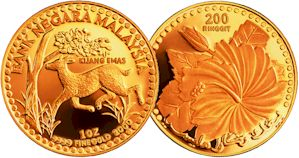

Die offizielle Goldbarrenmünze von Malaysia ist der Kijang Emas und wird von der Royal Mint of Malaysia geprägt.
Die Münze wird in den drei Einheinten: eine Unze, eine halbe Unze sowie eine Viertelunze ausgegeben, wobei eine Unze etwa 31,1g entspricht.

Zudem handelt es sich um 999er Gold (auch 24 Karat), weshalb der Kurs der Münze an den Goldpreis gebunden ist. Diese Münze wird auf der einen Seite von der Nationalblume Hibiskus und auf der anderen Seite von einem Reh, welches sehr typisch für das malayische Biotop ist, verziert.

Diese Arbeit beschäftigt sich mit der Anwendung von den Vorhersagemodellen Lineare Regression, ARIMA sowie LSTM auf die Zeitreihe der Goldmünzenpreise der Kijang Emas vom 03.01.2018 bis einschließlich dem 30.10.2020, wobei wir die Daten der offiziellen, malayischen Nationalbank "BANK NEGARA MALAYSIA" verwenden.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import Image
import csv
sns.set()

# 1. Datenimport
Die verwendeten Datensets beinhalten die Informationen der täglichen Handelspreise der malaysischen Goldbarrenmünze Kijang Emas mit 689 Beobachtungen seit 2018 bis Oktober 2020.

In [2]:
df = pd.read_excel ('Quelle.xlsx')

In [3]:
df.head(10)

,Date,1 oz Sell,1 oz Buy,1/2 oz Sell,1/2 oz Buy,1/4 oz Sell,1/4 oz Buy,Goldpreis in USD (Tagesschlusskurs),Goldpreis in MYR (Tagesschlusskurs),USD-MYR
0,2018-01-03,5632.0,5415.0,2869.0,2708.0,1461.0,1354.0,1318.88,5302.293264,4.0203
1,2018-01-04,5579.0,5362.0,2842.0,2681.0,1447.0,1341.0,1327.88,5316.300368,4.0036
2,2018-01-05,5608.0,5391.0,2857.0,2696.0,1455.0,1348.0,1319.58,5275.021050,3.9975
3,2018-01-08,5585.0,5371.0,2845.0,2685.0,1449.0,1343.0,1320.98,5291.053292,4.0054
4,2018-01-09,5592.0,5377.0,2849.0,2688.0,1451.0,1344.0,1311.50,5257.803500,4.0090
5,2018-01-10,5577.0,5359.0,2841.0,2680.0,1447.0,1340.0,1310.33,5247.216485,4.0045
6,2018-01-11,5599.0,5381.0,2853.0,2691.0,1453.0,1345.0,1325.78,5274.615730,3.9785
7,2018-01-12,5584.0,5369.0,2844.0,2684.0,1449.0,1342.0,1335.50,5311.951250,3.9775
8,2018-01-15,5622.0,5403.0,2864.0,2701.0,1458.0,1351.0,1340.80,5290.796800,3.9460
9,2018-01-16,5627.0,5409.0,2867.0,2705.0,1460.0,1352.0,1338.70,5303.260050,3.9615


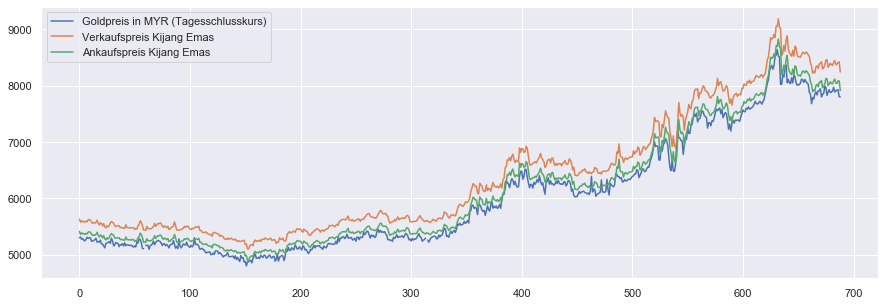

In [4]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(df["Goldpreis in MYR (Tagesschlusskurs)"], label = 'Goldpreis in MYR (Tagesschlusskurs)')
ax.plot(df["1 oz Sell"], label = 'Verkaufspreis Kijang Emas')
ax.plot(df["1 oz Buy"], label = 'Ankaufspreis Kijang Emas')
plt.legend()
plt.show()

In dieser Arbeit wird der Verkaufspreis für 1 oz Gold betrachtet

In [5]:
timestamp, selling = [], []  
timestamp = pd.DatetimeIndex(df['Date']).date
selling = selling = df["1 oz Sell"]
dfges = pd.DataFrame({'timestamp': timestamp, 'selling': selling})
len(timestamp), len(selling)

(689, 689)

# 2. Datenanalyse

### 2.1. Verteilungsanalyse

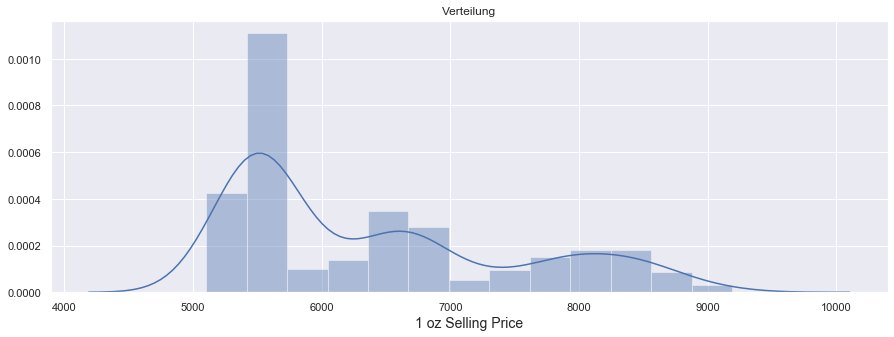

In [6]:
plt.figure(figsize = (15, 5))
sns.distplot(selling)
plt.xlabel("1 oz Selling Price", fontsize = 14)
plt.title("Verteilung")
plt.show()

### 2.2. Lagging Analyse
Eine Lag Diagramm zeigt eine Zeitreihe sowie diese um x Zeiteinheiten verschoben. Dieses wird verwendet, um Autokorrelationen zu finden.

Beispielsweise bedeutet ein Lag von fünf, dass wir eine zweite Zeitreihe erhalten, welche um eine Woche verschoben ist (Handelwoche = fünf Tage).

In [7]:
def df_shift(df, lag = 0, start = 1, skip = 1, rejected_columns = []):
    df = df.copy()
    if not lag:
        return df
    cols = {}
    for i in range(start, lag + 1, skip):
        for x in list(df.columns):
            if x not in rejected_columns:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k, v in cols.items():
        columns = v
        dfn = pd.DataFrame(data = None, columns = columns, index = df.index)
        i = start - 1
        for c in columns:
            dfn[c] = df[k].shift(periods = i)
            i += skip
        df = pd.concat([df, dfn], axis = 1)
        df = df.reindex(df.index) #"join_axes" was deprecated in version 0.25 for some reason. the same effect by reindexing.
    return df

In [8]:
dfges.head()

,timestamp,selling
0,2018-01-03,5632.0
1,2018-01-04,5579.0
2,2018-01-05,5608.0
3,2018-01-08,5585.0
4,2018-01-09,5592.0


Wir verschieben die Zeitreihe um 0, 6, 11, und 16 Zeiteinheiten.

In [9]:
df_crosscorrelated = df_shift(dfges, lag = 16, start = 1, skip = 5, rejected_columns = ['timestamp']
)
df_crosscorrelated['ma5'] = df_crosscorrelated['selling'].rolling(5).mean()
df_crosscorrelated['ma10'] = df_crosscorrelated['selling'].rolling(10).mean()
df_crosscorrelated['ma15'] = df_crosscorrelated['selling'].rolling(15).mean()

In [10]:
df_crosscorrelated.head(21) #selling_6: wir vergleichen die 1. Beobachtung mit der 6.Beobachtungen

,timestamp,selling,selling_1,selling_6,selling_11,selling_16,ma5,ma10,ma15
0,2018-01-03,5632.0,5632.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-04,5579.0,5579.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-05,5608.0,5608.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-08,5585.0,5585.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-09,5592.0,5592.0,NaN,NaN,NaN,5599.2,NaN,NaN
5,2018-01-10,5577.0,5577.0,5632.0,NaN,NaN,5588.2,NaN,NaN
6,2018-01-11,5599.0,5599.0,5579.0,NaN,NaN,5592.2,NaN,NaN
7,2018-01-12,5584.0,5584.0,5608.0,NaN,NaN,5587.4,NaN,NaN
8,2018-01-15,5622.0,5622.0,5585.0,NaN,NaN,5594.8,NaN,NaN
9,2018-01-16,5627.0,5627.0,5592.0,NaN,NaN,5601.8,5600.5,NaN


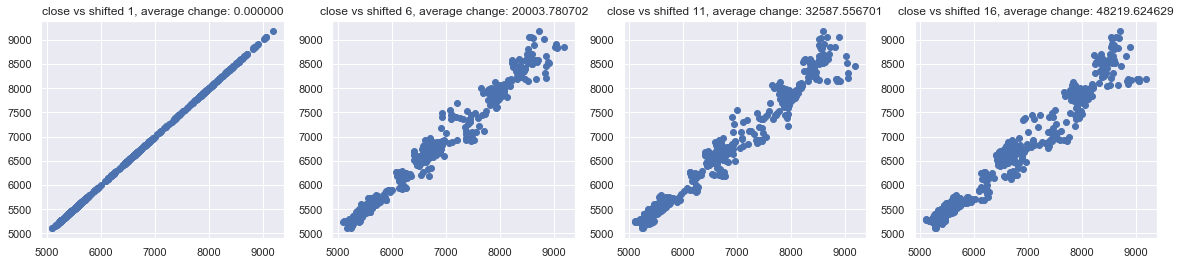

In [11]:
plt.figure(figsize = (20, 4))
plt.subplot(1, 4, 1)
plt.scatter(df_crosscorrelated['selling'], df_crosscorrelated['selling_1'])
mse = (
    (df_crosscorrelated['selling_1'] - df_crosscorrelated['selling']) ** 2
).mean()
plt.title('close vs shifted 1, average change: %f'%(mse))
plt.subplot(1, 4, 2)
plt.scatter(df_crosscorrelated['selling'], df_crosscorrelated['selling_6'])
mse = (
    (df_crosscorrelated['selling_6'] - df_crosscorrelated['selling']) ** 2
).mean()
plt.title('close vs shifted 6, average change: %f'%(mse))
plt.subplot(1, 4, 3)
plt.scatter(df_crosscorrelated['selling'], df_crosscorrelated['selling_11'])
mse = (
    (df_crosscorrelated['selling_11'] - df_crosscorrelated['selling']) ** 2
).mean()
plt.title('close vs shifted 11, average change: %f'%(mse))
plt.subplot(1, 4, 4)
plt.scatter(df_crosscorrelated['selling'], df_crosscorrelated['selling_16'])
mse = (
    (df_crosscorrelated['selling_16'] - df_crosscorrelated['selling']) ** 2
).mean()
plt.title('close vs shifted 16, average change: %f'%(mse))
plt.show()

Die MSE wird mit zunehmendem Shift größer, was zeigt wie schnell eine zufällige Zeitreihe seine Eigenschaften ändert / ändern kann.

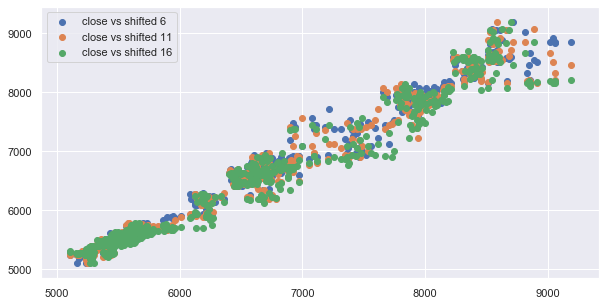

In [12]:
plt.figure(figsize = (10, 5))
plt.scatter(
    df_crosscorrelated['selling'],
    df_crosscorrelated['selling_6'],
    label = 'close vs shifted 6',
)
plt.scatter(
    df_crosscorrelated['selling'],
    df_crosscorrelated['selling_11'],
    label = 'close vs shifted 11',
)
plt.scatter(
    df_crosscorrelated['selling'],
    df_crosscorrelated['selling_16'],
    label = 'close vs shifted 16',
)
plt.legend()
plt.show()

Gleitende Durchschnitte werden häufig in der Zeitreihenanalyse verwenden und können auch zur Vorhersage zukünftiger Werte dienen. 

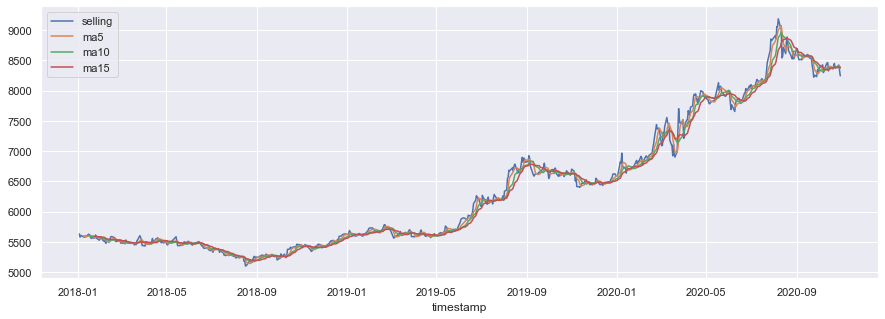

In [13]:
fig, ax = plt.subplots(figsize = (15, 5))
df_crosscorrelated.plot(
    x = 'timestamp', y = ['selling', 'ma5', 'ma10', 'ma15'], ax = ax
)

#### Korrelationsanalyse

In [14]:
df_crosscorrelated.corr().round(decimals = 4)

,selling,selling_1,selling_6,selling_11,selling_16,ma5,ma10,ma15
selling,1.0000,1.0000,0.9917,0.9870,0.9814,0.9979,0.9959,0.9942
selling_1,1.0000,1.0000,0.9917,0.9870,0.9814,0.9979,0.9959,0.9942
selling_6,0.9917,0.9917,1.0000,0.9916,0.9867,0.9962,0.9983,0.9974
selling_11,0.9870,0.9870,0.9916,1.0000,0.9914,0.9903,0.9945,0.9970
selling_16,0.9814,0.9814,0.9867,0.9914,1.0000,0.9852,0.9889,0.9926
ma5,0.9979,0.9979,0.9962,0.9903,0.9852,1.0000,0.9988,0.9972
ma10,0.9959,0.9959,0.9983,0.9945,0.9889,0.9988,1.0000,0.9993
ma15,0.9942,0.9942,0.9974,0.9970,0.9926,0.9972,0.9993,1.0000


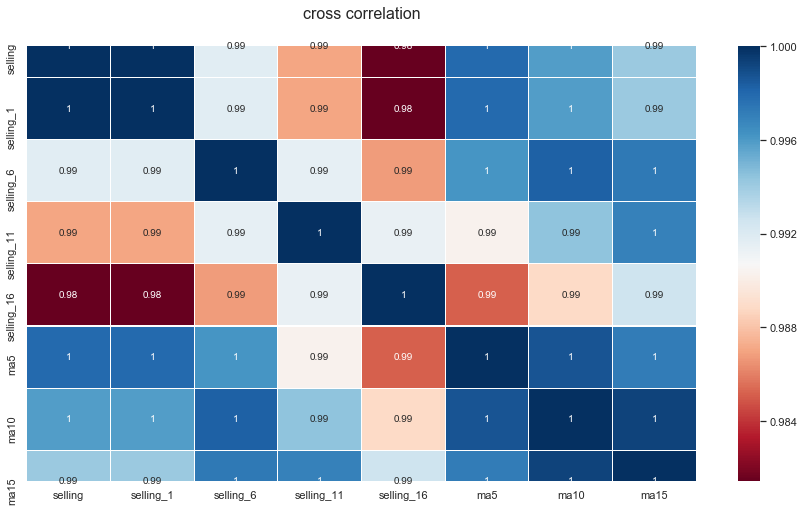

In [15]:
colormap = plt.cm.RdBu
plt.figure(figsize = (15, 8))
plt.title('cross correlation', y = 1.05, size = 16)

sns.heatmap(
    df_crosscorrelated.iloc[:, 1:].corr(),
    linewidths = 0.1,
    vmax = 1.0,
    cmap = colormap,
    linecolor = 'white',
    annot = True,
)
plt.show()

Wir betrachten die Korrelation von <b>selling vs selling_x</b>. Im obigen Bild können wir erkennen, dass die Korrelation von selling_6 bis selling_16 sich verringert.

#### Ausreißer
Der Z-Score (standardardisierte Residuen) einer Zeitreihe ermöglicht es uns innerhalb der Ausreißeranalyse extrem hohe und niedrige Werte zu finden.

In [16]:
std_selling = (selling - np.mean(selling)) / np.std(selling)

In [17]:
def detect(signal, treshold = 2.0): 
    detected = []
    for i in range(len(signal)):
        if np.abs(signal[i]) > treshold: #x<-2 oder x>2 als Ausreißer definiert
            detected.append(i)
    return detected

In [18]:
outliers = detect(std_selling)

C:\Users\zahra\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\zahra\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


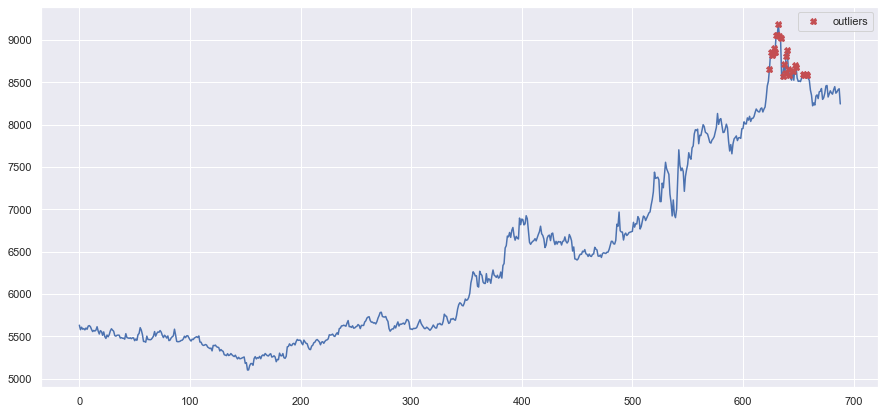

In [19]:
plt.figure(figsize = (15, 7))
plt.plot(selling)
plt.plot(
    np.arange(len(selling)),
    selling,
    'X',
    label = 'outliers',
    markevery = outliers,
    c = 'r',
)
plt.legend()
plt.show()

In [20]:
len(outliers)/len(selling)

0.036284470246734396

kleiner als 5%

### 2.3. Stationarität Analysis
2 Methoden, um  die Stationarität zu überprüfen, werden in dieser Arbeit implementiert: Summary statistic und Augmented Dickey-Fuller test

#### 1. Summary Statistics : Mean, Variance

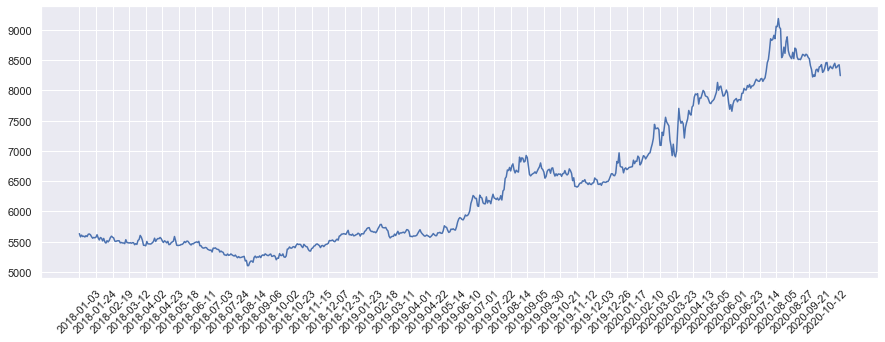

In [21]:
plt.figure(figsize = (15, 5))
plt.plot(selling)
plt.xticks(np.arange(len(timestamp))[::15], timestamp[::15], rotation = '45')
plt.show()

Im obigen Bild können wir erkennen, dass sich die Zeitreihe ab Anfang 2019 von ihren Eigenschaften ändert. Vor allem ist hier ersichtlich, dass der Trend zunehmend größer wird.

Eine schnelle Überprüfung, um festzustellen, ob eine Zeitreihe nicht stationär ist, die Berechnung des Mittelwerts und der Varianz. Dabei teilen wir in die Zeitreihe in zwei gleichlange Reihen auf und vergleichen die ersten beiden Momente miteinander, um festzustellen ob sie sich statistisch signifikant ändern.

In [22]:
X = selling.values
split = round(len(X) / 2)
Half1, Half2 = X[0:split], X[split:]
time1, time2 = timestamp[0:split], timestamp[split:]
meanH1, meanH2 = Half1.mean(), Half2.mean()
varH1, varH2 = Half1.var(), Half2.var()
print('meanH1=%f, meanH2=%f' % (meanH1, meanH2))
print('varianceH1=%f, varianceH2=%f' % (varH1, varH2))

meanH1=5494.976744, meanH2=7290.466667
varianceH1=22011.400622, varianceH2=739592.440193


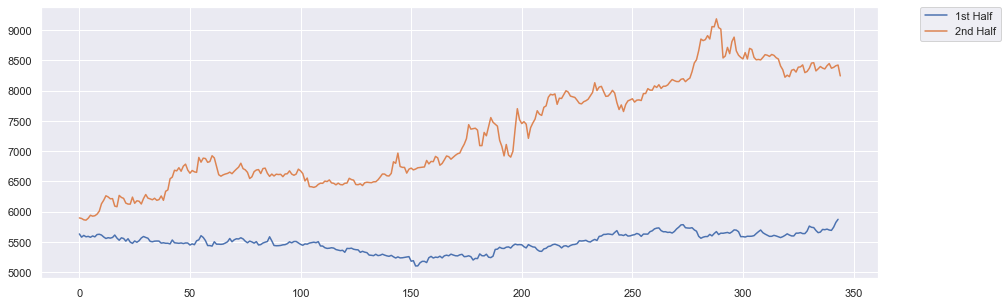

In [23]:
plt.figure(figsize = (15, 5))
plt.plot(Half1, label="1st Half")
plt.plot(Half2, label= "2nd Half")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

Nach der Berechnung der ersten beiden Momente sehen wir, dass es einen signifikanten Unterschied gibt. Im Plot ist es ersichtlich, dass der Graph der ersten Hälfte keinen Trend hat, wohingegen die zweite Hälfte einen positiven Trend zeigt.

In [24]:
X = selling.values
split = round(len(X) / 4)
Q1, Q2, Q3, Q4 = X[0:split], X[split: 2*split], X[2*split: 3*split], X[3*split:]
meanQ1, meanQ2, meanQ3, meanQ4 = Q1.mean(), Q2.mean(), Q3.mean(), Q4.mean()
varQ1, varQ2, varQ3, varQ4 = Q1.var(), Q2.var(), Q3.var(), Q4.var()
print('meanQ1=%f, meanQ2=%f, meanQ3=%f, meanQ4=%f' % (meanQ1, meanQ2, meanQ3, meanQ4))
print('varianceQ1=%f, varianceQ2=%f, varianceQ3=%f, varianceQ4=%f' % (varQ1, varQ2, varQ3, varQ4))

meanQ1=5431.558140, meanQ2=5558.395349, meanQ3=6529.476744, meanQ4=8047.057803
varianceQ1=15445.048945, varianceQ2=20533.913467, varianceQ3=68845.551785, varianceQ4=258273.800127


#### 2. Statistical Test : Augmented Dickey-Fuller test

Der Augmented Dickey-Fuller-Test ist ein statistischer Test, der als Einheitswurzeltest bezeichnet wird. Der Einheitswurzeltest ermittelt, wie stark eine Zeitreihe durch einen Trend definiert ist.

Die Nullhypothese des Tests ist, dass die Zeitreihen durch eine Einheitswurzel dargestellt werden kann (d.h. eine zeitabhängige Struktur aufweist oder nicht stationär). Die alternative Hypothese (Ablehnung der Nullhypothese) ist, dass die Zeitreihe stationär ist.

Nullhypothese (H0): Wenn sie nicht abgelehnt wird, bedeutet das, dass die Zeitreihe eine Einheitswurzel hat -> Es liegt eine zeitabhängige Struktur vor. 

Alternative Hypothese (H1): Die Nullhypothese wird verworfen; es deutet darauf hin, dass die Zeitreihe keine Einheitswurzel hat -> dass sie stationär ist und es liegt keine zeitabhängige Struktur vor.

Wir überprüfen dieses Ergebnis anhand des p-Werts. Ein p-Wert unter 5% bedeutet, dass die Nullhypothese zu dem Konfidenzniveau 95% abgelehnt wird (stationär), andernfalls wird die Nullhypothese (nicht stationär) nicht abgelehnt.

p-Wert> 0,05: Wenn die Nullhypothese (H0) nicht verworfen wird, haben die Daten eine Einheitswurzel und sind nicht stationär. p-Wert <= 0,05: Die Nullhypothese (H0) ablehnen, die Daten haben keine Einheitswurzel und sind stationär.

In [25]:
dfges = pd.DataFrame({'timestamp': timestamp, 'selling': selling})
df1 = pd.DataFrame({'timestamp1': time1, 'selling1': Half1})
df2 = pd.DataFrame({'timestamp2': time2, 'selling2': Half2})
gesdiff = dfges.diff()
diff2 = df2.diff()
selldiff = gesdiff["selling"].values
sell2 = diff2["selling2"].values
selldiff[0] = 0
sell2[0] = 0

Zur Berechnung des ADF-test kann die Funktion <b>adfuller</b> von statsmodels.tsa.stattools verwendet werden.

In [26]:
from statsmodels.tsa.stattools import adfuller

def ADF_Test(time_series):
    result = adfuller(time_series)
    print('\033[01m' + '\033[04m' + 'Augmented Dicky-Fuller Test' + '\033[0m')
    labels = ['ADF Test Statistics', 'p-value', '# Lags used', '# Observations used']
    
    for value, label in zip(result, labels):
        print(label + ': ' + str(value))
   
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.4f' % (key, value))
        
    if result[1] <= 0.05:
        print('\033[01m' + '\033[91m' + 'Reject the null hypothesis!' + '\033[0m')
        print('Data has no unit root and the time series is stationary.')
    else:
        print('\033[01m' + '\033[91m' + "Fail to reject the null hypothesis!" + '\033[0m')
        print('Data has a unit root and the time series is non-stationary.')

In [27]:
ADF_Test(dfges['selling'])

Augmented Dicky-Fuller Test
ADF Test Statistics: 0.34880419323493866
p-value: 0.9794760761399781
# Lags used: 16
# Observations used: 672
Critical Values:
	1%: -3.4401
	5%: -2.8659
	10%: -2.5691
Fail to reject the null hypothesis!
Data has a unit root and the time series is non-stationary.


In [28]:
ADF_Test(df1['selling1'])

Augmented Dicky-Fuller Test
ADF Test Statistics: -0.3745262172422309
p-value: 0.9142658940726225
# Lags used: 8
# Observations used: 335
Critical Values:
	1%: -3.4500
	5%: -2.8702
	10%: -2.5714
Fail to reject the null hypothesis!
Data has a unit root and the time series is non-stationary.


In [29]:
ADF_Test(df2['selling2'])

Augmented Dicky-Fuller Test
ADF Test Statistics: -1.3077768915694523
p-value: 0.6256069082362476
# Lags used: 0
# Observations used: 344
Critical Values:
	1%: -3.4495
	5%: -2.8700
	10%: -2.5713
Fail to reject the null hypothesis!
Data has a unit root and the time series is non-stationary.


Die p-Werte zeigen, dass alle drei Zeitreihen (Gesamt, 1stHalf, 2nd Half) nicht stationär sind.
# 3. Datenmanipulatioin - Detrending

Trendbereinigung der Zeitreihe (Detrending)

1. Transformationen: Log Transformation, Square Root Transformation, Cubed Root Transformation
2. Gleitender Durchschnitt zur Glättung der Zeitreihe: Einfacher gleitender Durchschnitt sowie gewichteter gleitender Durchschnitt
3. Differenzierung der Zeitreihe

In [30]:
dftrans = dfges.set_index('timestamp')
dftrans.head()

,selling
timestamp,
2018-01-03,5632.0
2018-01-04,5579.0
2018-01-05,5608.0
2018-01-08,5585.0
2018-01-09,5592.0


### 3.1. Transformationen
Log Transformation, Square Root Transformation, Cubed Root Transformation

In [31]:
# Berechne den Logarithmus der Verkaufspreise
dftrans['selling_log'] = np.log(dftrans['selling'])

# Berechne die Quadratwurzel der Verkaufspreise
dftrans['selling_sqrt'] = np.sqrt(dftrans['selling'])

# Berechne die dritte Wurzel der Verkaufspreise
dftrans['selling_cbrt'] = np.cbrt(dftrans['selling'])

dftrans.head()

,selling,selling_log,selling_sqrt,selling_cbrt
timestamp,,,,
2018-01-03,5632.0,8.636220,75.046652,17.791841
2018-01-04,5579.0,8.626765,74.692704,17.735855
2018-01-05,5608.0,8.631949,74.886581,17.766532
2018-01-08,5585.0,8.627840,74.732858,17.742210
2018-01-09,5592.0,8.629092,74.779676,17.749620


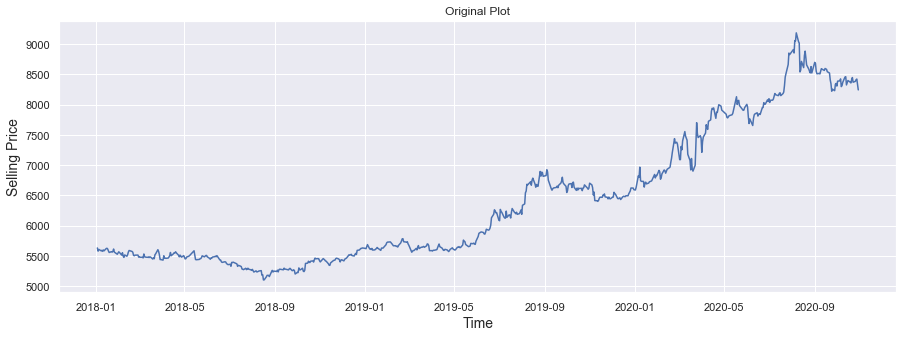

In [32]:
dftrans['selling'].plot(figsize = (15, 5))
plt.xlabel("Time", fontsize = 14)
plt.ylabel("Selling Price", fontsize = 14)
plt.title("Original Plot")
plt.show()

#### 3.1.1. Log Transformation

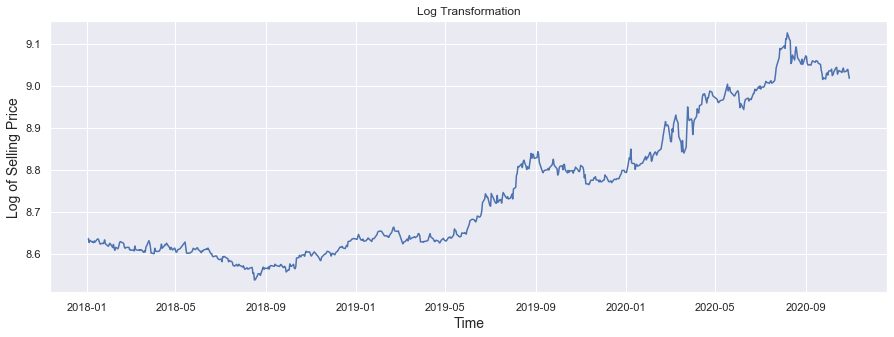

In [33]:
dftrans['selling_log'].plot(figsize = (15, 5))
plt.xlabel("Time", fontsize = 14)
plt.ylabel("Log of Selling Price", fontsize = 14)
plt.title("Log Transformation")
plt.show()

#### 3.1.2. Square Root Transformation

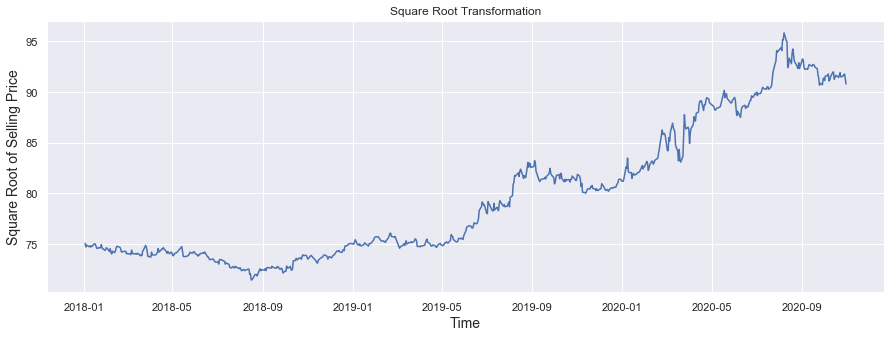

In [34]:
dftrans['selling_sqrt'].plot(figsize = (15, 5))
plt.xlabel("Time", fontsize = 14)
plt.ylabel("Square Root of Selling Price", fontsize = 14)
plt.title("Square Root Transformation")
plt.show()

#### 3.1.3. Cube Root Transformation

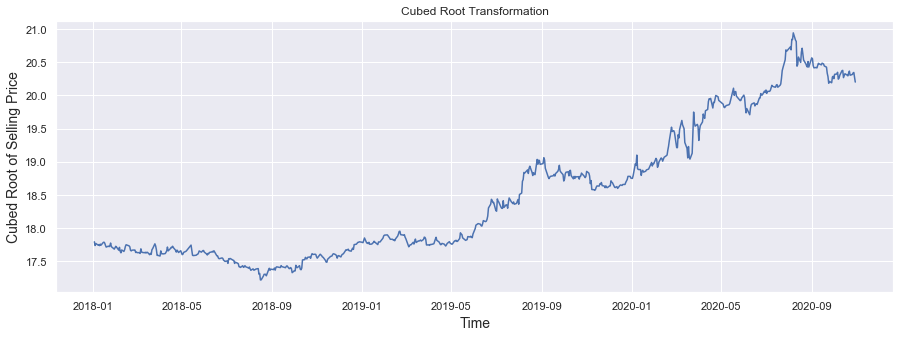

In [35]:
dftrans['selling_cbrt'].plot(figsize = (15, 5))
plt.xlabel("Time", fontsize = 14)
plt.ylabel("Cubed Root of Selling Price", fontsize = 14)
plt.title("Cubed Root Transformation")
plt.show()

### 3.2. Entferne den gleitenden Durchschnitt von der Originalzeitreihe
Um die Zeitreihe stationär zu machen, versuchen wir einen geeigneten gleitenden Durchschnitt zu finden. Der gleitende Durchschnitt wird über die gesamte Zeitreihe hinweg mit der gleichen Anzahl an Beobachtungen gebildet. Dabei ist darauf zu achten, dass die Abstände zwischen zwei Zeitpunkten gleich sind. 

Uns liegen Tagesdaten vor, welche auf die Handelstage beschränkt sind. Daher haben wir uns entschlossen, den gleitenden Durchschnitt über 20 Handelstage zu bilden, so dass wir immer den Mittelwert von vier Handelswochen aus unserer Zeitreihe entfernen. 

Zur Berechnung des gleitenden Durchschnitts kann die Methode rolling() von Pandas verwendet werden.

####  3.2.1. Einfacher gleitender Durchschnitt / Removing The Simple Rolling Mean

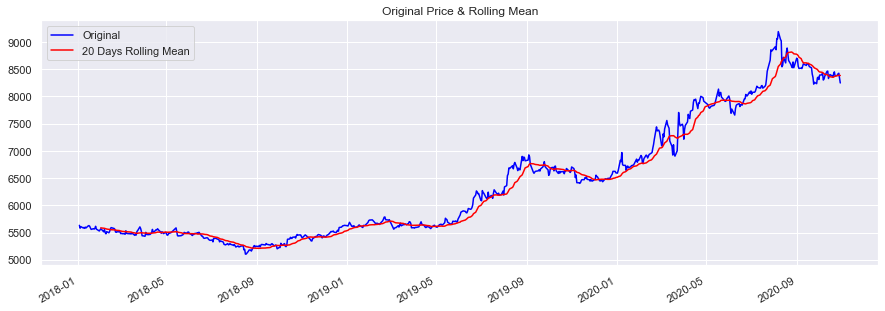

In [36]:
rolmean = dftrans['selling'].rolling(window = 20).mean()

fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(dftrans['selling'], color = 'blue', label = 'Original')
ax.plot(rolmean, color = 'red', label = '20 Days Rolling Mean')
ax.legend(loc = 'best')
plt.title('Original Price & Rolling Mean')
fig.autofmt_xdate()
plt.show(block = False)

In [37]:
# Subtrahiere den einfachen gleitenden Durchschnitt von den Originaldaten 
# und überprüfe auf NaNs
data_minus_rolmean = dftrans['selling'] - rolmean
data_minus_rolmean[15:25]

timestamp
2018-01-24      NaN
2018-01-25      NaN
2018-01-26      NaN
2018-01-30      NaN
2018-02-01   -18.90
2018-02-02   -26.15
2018-02-05   -66.85
2018-02-06   -24.10
2018-02-07   -75.70
2018-02-08   -90.90
Name: selling, dtype: float64

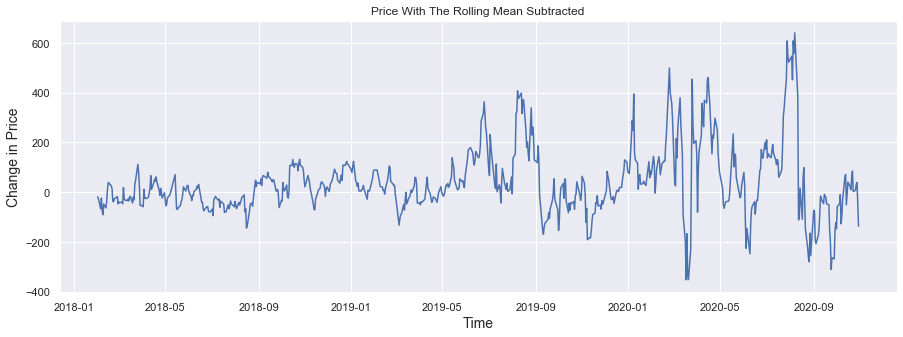

In [38]:
# Lösche die NaNs aus der oben berechneten Zeitreihe
data_minus_rolmean.dropna(inplace = True)

data_minus_rolmean.plot(figsize = (15, 5))
plt.xlabel("Time", fontsize = 14)
plt.ylabel("Change in Price", fontsize = 14)
plt.title("Price With The Rolling Mean Subtracted")
plt.show()

Wir sehen, dass der positive Trend aus der Reihe entfernt wurde, wobei die Varianz in der zweiten Hälfte größer scheint als vorher. Für die Überprüfung der Stationarität führen wieder den Augmented Dicky-Fuller Test durch.

In [39]:
ADF_Test(data_minus_rolmean)

Augmented Dicky-Fuller Test
ADF Test Statistics: -4.880606985236116
p-value: 3.8035775411476196e-05
# Lags used: 16
# Observations used: 653
Critical Values:
	1%: -3.4404
	5%: -2.8660
	10%: -2.5691
Reject the null hypothesis!
Data has no unit root and the time series is stationary.


####  3.2.2. Gewichteter gleitender Durchschnitt / Entfernen des gewichteten gleitenden Durchschnitts

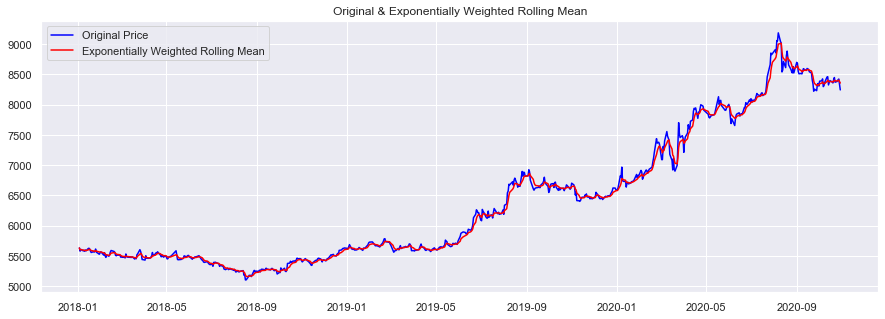

In [40]:
# Exponentiell geglätteter Durchschnitt / Exponentially Weighted Moving Average (EWMA)
exp_rolmean = dftrans['selling'].ewm(halflife = 2).mean()

fig, ax = plt.subplots(figsize = (15, 5))
orig = plt.plot(dftrans['selling'], color = 'blue', label = 'Original Price')
mean = plt.plot(exp_rolmean, color = 'red', label = 'Exponentially Weighted Rolling Mean')
plt.legend(loc = 'best')
plt.title('Original & Exponentially Weighted Rolling Mean')
plt.show(block = False)

In [41]:
# Subtrahiere den EWMA von den Originaldaten und überprüfe auf NaNs
data_minus_exp_rolmean = dftrans['selling'] - exp_rolmean
data_minus_exp_rolmean[15:25]

timestamp
2018-01-24    -2.140176
2018-01-25    26.740225
2018-01-26   -17.140347
2018-01-30   -36.847672
2018-02-01     2.228130
2018-02-02    -6.200874
2018-02-05   -35.490195
2018-02-06     3.188457
2018-02-07   -37.339623
2018-02-08   -41.249392
Name: selling, dtype: float64

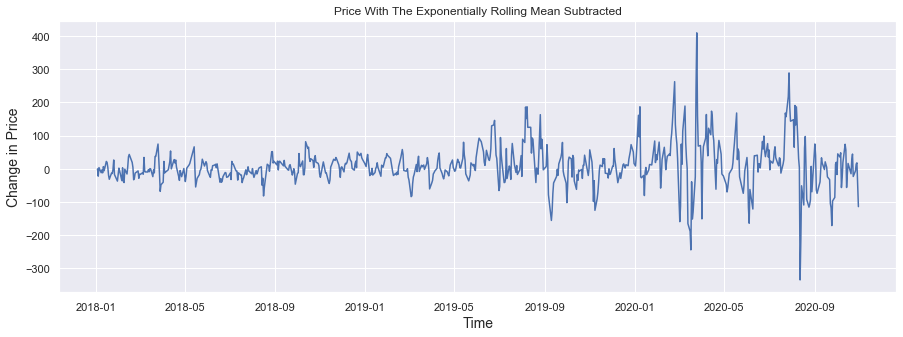

In [42]:
data_minus_exp_rolmean.plot(figsize = (15, 5))
plt.xlabel("Time", fontsize = 14)
plt.ylabel("Change in Price", fontsize = 14)
plt.title("Price With The Exponentially Rolling Mean Subtracted")
plt.show()

In [43]:
ADF_Test(data_minus_exp_rolmean)

Augmented Dicky-Fuller Test
ADF Test Statistics: -5.81720199482186
p-value: 4.2649747389117835e-07
# Lags used: 16
# Observations used: 672
Critical Values:
	1%: -3.4401
	5%: -2.8659
	10%: -2.5691
Reject the null hypothesis!
Data has no unit root and the time series is stationary.


### 3.3. Differenzierung
Die Differenzierung ist eine Methode zum Transformieren eines Zeitreihendatensatzes. Die Differenzierung erfolgt durch Subtrahieren der vorherigen Beobachtung von der aktuellen Beobachtung. Die Differenzenbildung einer Zeitreihe trägt dazu bei, den Mittelwert der Zeitreihen zu stabilisieren, da die Ausschläge der Zeitreihe entfernt wir, wodurch der Trend und die Saisonalität eliminiert (oder reduziert) wird.

In [44]:
data_diff = dftrans['selling'].diff(periods = 1)
data_diff.head(4)

timestamp
2018-01-03     NaN
2018-01-04   -53.0
2018-01-05    29.0
2018-01-08   -23.0
Name: selling, dtype: float64

In [45]:
data_diff.dropna(inplace = True)
data_diff.head(4)

timestamp
2018-01-04   -53.0
2018-01-05    29.0
2018-01-08   -23.0
2018-01-09     7.0
Name: selling, dtype: float64

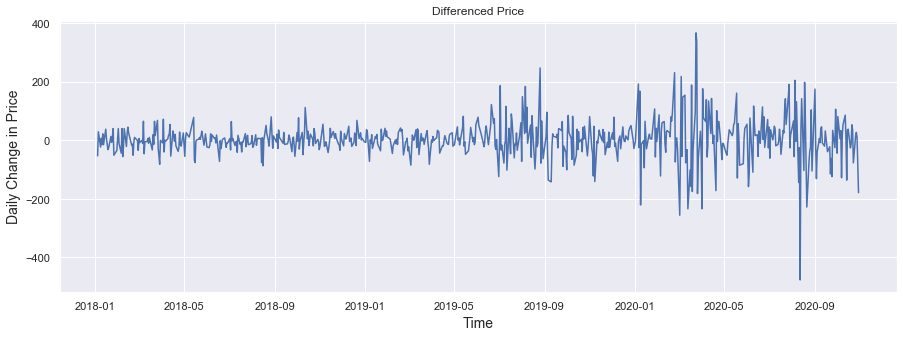

In [46]:
data_diff.plot(figsize = (15, 5))
plt.xlabel("Time", fontsize = 14)
plt.ylabel("Daily Change in Price", fontsize = 14)
plt.title('Differenced Price')
plt.show(block = False)

Nach der Differenzierung könne wir keinen Aufwärtstrend mehr erkennen, allerdings ist die Varianz immer noch zeitabhängig.

In [47]:
ADF_Test(data_diff)

Augmented Dicky-Fuller Test
ADF Test Statistics: -6.676318614963377
p-value: 4.455910123839696e-09
# Lags used: 15
# Observations used: 672
Critical Values:
	1%: -3.4401
	5%: -2.8659
	10%: -2.5691
Reject the null hypothesis!
Data has no unit root and the time series is stationary.


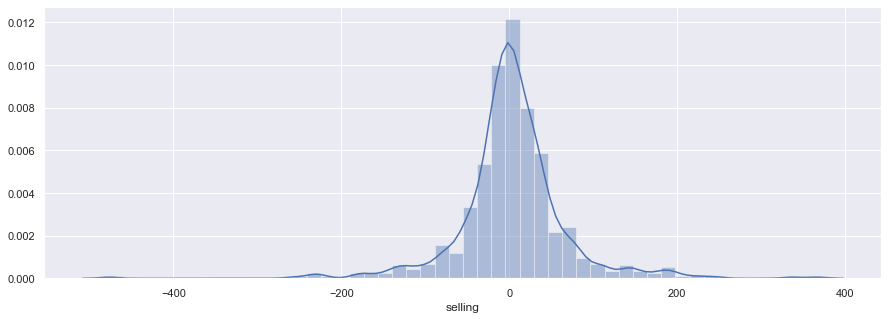

In [48]:
plt.figure(figsize = (15, 5))
sns.distplot(data_diff)
plt.show()

In der Verteilungsanalyse der differenzierten Zeitreihe ist die Gauß’sche Glockenkurve klar erkenntlich.

# 4. Predictive Modelling
# 4.1. Predictive Modelling mit Lineare Regression

Ein Beispiel des überwachten Lernens ist die lineare Regression. Lineare Regression wird verwendet, um die realen Werte basierend auf kontinuierlichen Variablen zu schätzen. Hier wird eine lineare Beziehung zwischen zwei oder mehreren Variablen untersucht, in dem der beste funktionale Zusammenhang zwischen abhängiger Variable (auch erklärte Variable) und mindestens einer unabhängigen Variable (auch erklärende Variable) angepasst wird. Ist $Y$ die abhängige Variable und $X$ die unabhängige, so lautet die Gleichung der linearen Regression die folgendermaßen
\begin{align*}
  y_{i}=\beta _{0}+\beta _{1}x_{i1}+ \beta _{2}x_{i2} + ... + \beta _{n}x_{in} + \varepsilon _{i}
\end{align*}
wobei $x_i$ ein Tupel aller Merkmale einer Stichprobe ist und $x_{ij}$ das j-te Merkmal der i-ten Stichprobe ist. $y_i$ sind konkrete Werte der abhängigen Variablen und $\beta$ ist die Menge der Gewichte, die sogenannte Regressionskoeffizienten, mit denen die unabhängigen Variablen multipliziert werden, um $y$ zu bekommen. Das Ziel der Modellanpassung ist es $\beta$ so zu wählen, dass die oben aufgeführte Gleichung die Daten bestmöglich abbildet.  
Da alle diese Variablen Vektoren oder Matrizen sind, kann man die Formel folgendermaßen zusammenfassen:
\begin{align*}
  Y_{i}=X\beta + \varepsilon  
\end{align*}
mit $X$ die Menge aller Stichproben des Datensatzes und $Y$ die Menge aller abhängigen Variablen, die für das Training benutzt, vorhergesagt oder klassifiziert werden. 
Da wir mithilfe des linearen Modells die Fehlerterm $\varepsilon _{i}$ nicht berechnen können, sieht die Vorhersage folgendermaßen aus:
\begin{align*}
  \hat{Y}_{i}=X\beta
\end{align*}

In [49]:
from sklearn.linear_model import LinearRegression

### 4.1.1. Lineare Regression - Modell mit der ursprünglichen Zeitreihen

<b> Erstellen der Trainings- und Testdatasets </b>

Dabei wird darauf geachtet, dass wir genau 61 Tage für das Backtesting zur Verfügung haben.

In [50]:
#the training data is used to create the linear regression model, by pairing the input with the expected output
#the test data is used to estimate how well the model has been trained
train_selling= selling[:628] 
test_selling = selling[628:]

future_count = len(test_selling)
print(future_count) #predicting 61 days

61


<b> Modelltraining und Erstellung der Vorhersage

In [51]:
%%time
linear_regression = LinearRegression().fit(
    np.arange(len(train_selling)).reshape((-1, 1)), train_selling
)
linear_future = linear_regression.predict(
    np.arange(len(train_selling) + future_count).reshape((-1, 1))
)

Wall time: 997 µs


<b>Plot

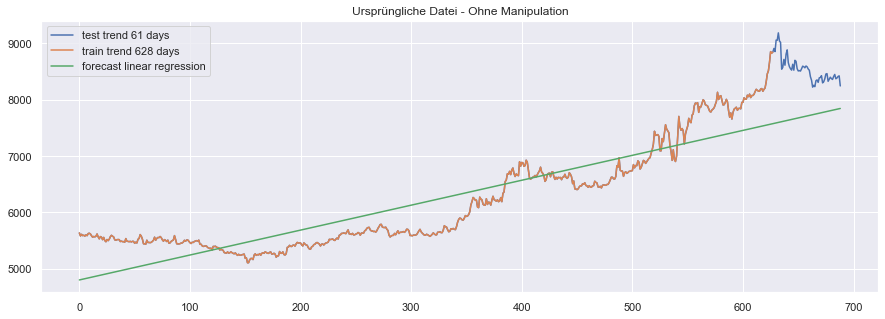

In [52]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(selling, label = 'test trend 61 days')
ax.plot(train_selling, label = 'train trend 628 days')
ax.plot(linear_future, label = 'forecast linear regression')
plt.title('Ursprüngliche Datei - Ohne Manipulation')
plt.legend()
plt.show()

### 4.1.2. Lineare Regression - Modell mit Rolling Mean

<b> Erstellen der Trainings- und Testdatasets </b>

In [53]:
rolmean = dfges['selling'].rolling(window = 20).mean()
data_minus_rolmean = dfges['selling'] - rolmean
data_minus_rolmean[15:25]
data_minus_rolmean.dropna(inplace = True)

In [54]:
train_sellingrm = data_minus_rolmean[:609]
test_sellingrm = data_minus_rolmean[609:]

future_countrm = len(test_sellingrm)
print(future_countrm)

61


<b> Modelltraining und Erstellung der Vorhersage

In [55]:
%%time
linear_regressionrm = LinearRegression().fit(
    np.arange(len(train_sellingrm)).reshape((-1, 1)), train_sellingrm
)
linear_futurerm = linear_regressionrm.predict(
    np.arange(len(train_sellingrm) + future_countrm).reshape((-1, 1))
)

linear_futurerm[0:21]

Wall time: 995 µs


array([-34.36978196, -34.10884623, -33.8479105 , -33.58697477,
       -33.32603904, -33.06510331, -32.80416758, -32.54323185,
       -32.28229612, -32.02136039, -31.76042466, -31.49948893,
       -31.23855321, -30.97761748, -30.71668175, -30.45574602,
       -30.19481029, -29.93387456, -29.67293883, -29.4120031 ,
       -29.15106737])

<b>Plot

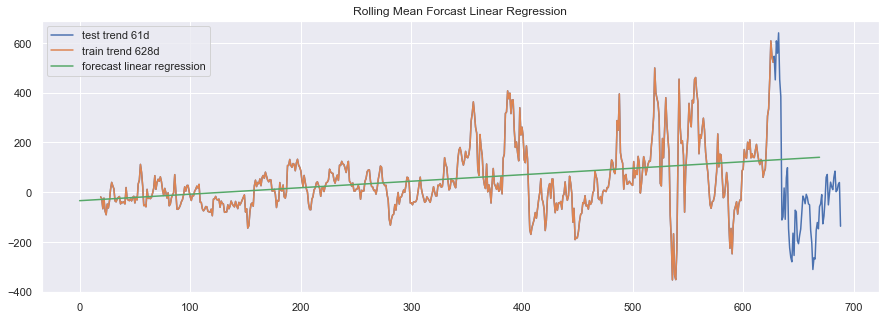

In [56]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(data_minus_rolmean, label = 'test trend 61d')
ax.plot(train_sellingrm, label = 'train trend 628d')
ax.plot(linear_futurerm, label = 'forecast linear regression')
plt.title('Rolling Mean Forcast Linear Regression')
plt.legend()
plt.show()

<b> Rücktransformation der Werte & Plot

In [57]:
linear_rmretrans = train_selling[19] + np.cumsum(linear_futurerm)
linear_rmretrans[1:10]

array([5499.52137181, 5465.67346131, 5432.08648654, 5398.7604475 ,
       5365.69534419, 5332.89117661, 5300.34794475, 5268.06564863,
       5236.04428824])

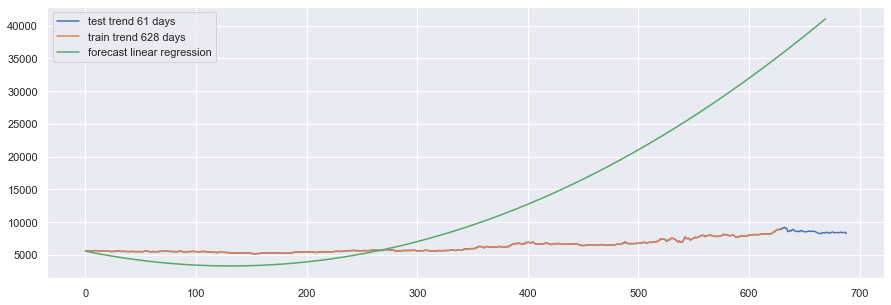

In [58]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(selling, label = 'test trend 61 days')
ax.plot(train_selling, label = 'train trend 628 days')
ax.plot(linear_rmretrans, label = 'forecast linear regression')
plt.legend()
plt.show()

### 4.1.3. Lineare Regression - Modell mit differenzierter Zeitreihe

<b> Erstellen der Trainings- und Testdatasets

In [59]:
train_sellingdiff= selldiff[:628]
test_sellingdiff = selldiff[628:]

future_countdiff = len(test_sellingdiff)
print(future_countdiff)

61


<b> Modelltraining und Erstellung der Vorhersage

In [60]:
%%time
linear_regressiondiff = LinearRegression().fit(
    np.arange(len(train_sellingdiff)).reshape((-1, 1)), train_sellingdiff
)
linear_futurediff = linear_regressiondiff.predict(
    np.arange(len(train_sellingdiff) + future_countdiff).reshape((-1, 1))
)

linear_futurediff[0:21]

Wall time: 0 ns


array([-4.95109516, -4.91898244, -4.88686972, -4.854757  , -4.82264428,
       -4.79053156, -4.75841885, -4.72630613, -4.69419341, -4.66208069,
       -4.62996797, -4.59785526, -4.56574254, -4.53362982, -4.5015171 ,
       -4.46940438, -4.43729166, -4.40517895, -4.37306623, -4.34095351,
       -4.30884079])

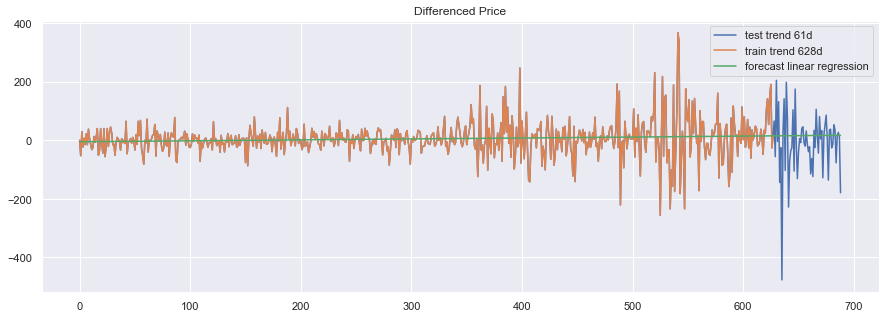

In [61]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(selldiff, label = 'test trend 61d')
ax.plot(train_sellingdiff, label = 'train trend 628d')
ax.plot(linear_futurediff, label = 'forecast linear regression')
plt.title('Differenced Price')
plt.legend()
plt.show()

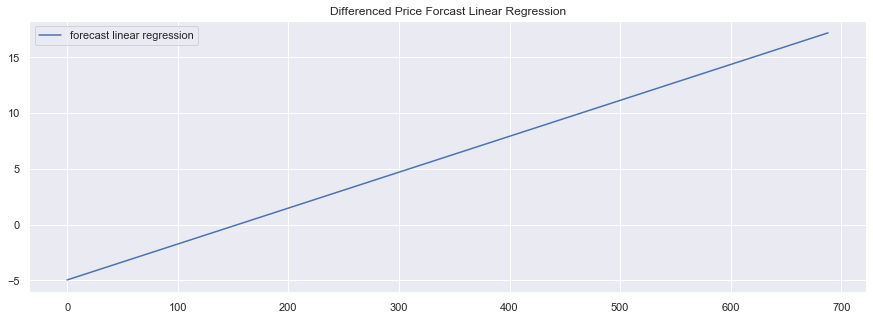

In [62]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(linear_futurediff, label = 'forecast linear regression')
plt.title('Differenced Price Forcast Linear Regression')
plt.legend()
plt.show()

<b> Rücktransformation der Werte & Plot

In [63]:
linear_diffcumsum = train_selling[0] + np.cumsum(linear_futurediff)
linear_diffcumsum[1:10]

array([5622.12992241, 5617.24305269, 5612.38829568, 5607.5656514 ,
       5602.77511984, 5598.01670099, 5593.29039486, 5588.59620145,
       5583.93412076])

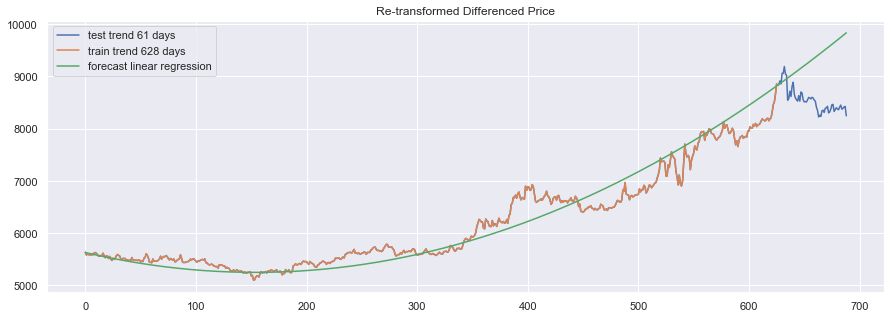

In [64]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(selling, label = 'test trend 61 days')
ax.plot(train_selling, label = 'train trend 628 days')
ax.plot(linear_diffcumsum, label = 'forecast linear regression')
plt.title('Re-transformed Differenced Price')
plt.legend()
plt.show()

# 4.2. Predictive Modelling mit ARIMA

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

In [66]:
df3 = dfges.set_index('timestamp')
df3.head()

,selling
timestamp,
2018-01-03,5632.0
2018-01-04,5579.0
2018-01-05,5608.0
2018-01-08,5585.0
2018-01-09,5592.0


## 4.2.1 Autoregressive Integrated Moving Average Model (ARIMA)

Zur Parametrisierung von ARIMA werden $p, d, q$ verwendet, wobei
* <b>$p$ der Autoregressive Teil (AR) des Modells ist.</b> Es ermöglicht uns, den Effekt vergangener Werte in unser Modell einzubeziehen. Intuitiv ähnelt dies der Aussage, dass es morgen wahrscheinlich warm sein wird, wenn es heute warm ist.
* <b>$q$ der Moving Average Teil (MA) bzw. der gleitende Durchschnittsteil des Modells ist.</b> Dies ermöglicht es uns, den Fehler unseres Modells als lineare Kombination der Fehlerwerte festzulegen, die zu früheren Zeitpunkten in der Vergangenheit beobachtet wurden.
* <b>$d$ der integrierte Teil (I) des Modells ist.</b> Dies schließt Terme in das Modell ein, die das Ausmaß der Differenzierung (d.h. die Anzahl vergangener Zeitpunkte, die vom aktuellen Wert subtrahiert werden sollen) enthalten, um auf die Zeitreihen anzuwenden. Intuitiv wäre dies ähnlich wie die Aussage, dass es morgen wahrscheinlich dieselbe Temperatur sein wird, wenn der Temperaturunterschied in den letzten drei Tagen sehr gering war.

Ein stochastischer Prozess wird als ARIMA($p,d,q$)-Prozess definiert, wenn dessen Differenz der Ordnung $d$ ein stationärer ARMA($p,q$)-Prozess von der Form
\begin{align*}
X_t=\varphi_0+\sum_{i=1}^{p}\varphi_iX_{t-i}+\varepsilon_t+\sum_{i=1}^{q}\theta_i\varepsilon_{t-i}
\end{align*}
ist. 

<b>Die Hauptschritte bei der Modellanpassung eines ARIMA-Modells:</b>

<b>1) Modellidentifizierung</b> 
* Ziel der Identifikation ist es, die Spezifikationsparameter $d$, $p$ und $q$ zu bestimmen
* $d$ ist die Anzahl der notwendigen Differenzierungen, um die Zeitreihe stationär zu machen. Zur Bestimmung von $d$ können Einheitswurzeltests (z.B. Dickey-Fuller-Test) verwendet werden 
* Für die Ordnungen $p$ und $q$ werden häufig die Autokorrelationsfunktion (ACF) und die partielle Autokorrelationsfunktion (PACF) herangezogen sowie Kriterien zur Modellselektion, wie das Akaike-Informationskriterium (AIC) oder das Bayessche Informationskriterium (BIC)

<b>2) Parameterschätzung</b>
* Ermitteln von Koeffizienten des Regressionsmodells unter Verwendung von Anpassungsverfahren
* Maximum-Likelihood-Methode 
* Kleinste-Quadrate-Methode

<b>3) Modellüberprüfung</b>
* Residuen des angepassten Modells berechnen
* Überprüfen, ob die Residuen unabhängig und identisch verteilt sind mit Erwartungswert Null und Varianz $\sigma^2$ wie White Noise
* Überprüfung der Signifikanz einzelner Parameter

In der Regel muss man diese drei Schritte bei einer gegebenen Zeitreihe mehrmals wiederholen, bevor ein geeignetes Modell gefunden ist.

<b>Zur Erinnerung: Autokorrelationsfunktion (ACF) und partielle Autokorrelationsfunktion (PACF)</b>

<b>Autokorrelationsfunktion (ACF)</b>: $\rho(\tau)=\frac{\gamma(\tau)}{\gamma(0)}=\frac{Cov(X_t,X_{t+\tau})}{Var(X_t)}; \tau\in\mathbb{Z}$

Das ist der Korrelationskoeffizient zwischen den Zufallsvariablen $X_t$ und $X_{t+\tau}$, der wegen der Stationarität nicht von $t$, wohl aber von der Zeitdifferenz $\tau$ abhängen kann. $\rho(\tau)$ ist somit ein Maß für die lineare Abhängigkeit zwischen zwei Prozessvariablen, die um $\tau$ Zeiteinheiten auseinander liegen. In diesem Zusammenhang wird $\tau$ auch als <b>Lag</b> bezeichnet.

Eine wichtige Anwendung der ACF ist die folgende: Man unterstellt, dass der charakteristische Verlauf der empirischen ACF auch der der theoretischen ACF ist, und kann so auf den Typ des zugrundeliegenden stationären stochastischen Prozesses schließen. Wenn man sich jedoch speziell für die Ordnung eines linearen autoregressiven Prozesses interessiert, ist die partielle Autokorrelationsfunktion besser geeignet.


<b>Partielle Autokorrelationsfunktion (PACF)</b>: 
$\pi(\tau) = 
\begin{cases}
\varphi_{\tau,\tau} & \tau=1,2,\dots \\
0 & \tau=0\\
\pi(-\tau) & \tau=-1,-2,\dots
\end{cases}$

Diese Funktion an der Stelle $\tau$ gibt den partiellen Korrelationskoeffizienten zwischen zwei Prozessvariablen, die $\tau$ Zeiteinheiten auseinander liegen, unter Ausschluss des Einflusses der zeitlich dazwischen liegenden Prozessvariablen wieder. Dieser Koeffizient ist ein Maß für den linearen Zusammenhang zwischen $X_t$ und $X_{t+\tau}$ unter Ausschaltung des linearen Einflusses von $X_{t+1}, \dots, X_{t+\tau-1}$. Dadurch wird eine durch die Zwischenvariablen erzeugte Scheinkorrelation beseitigt.

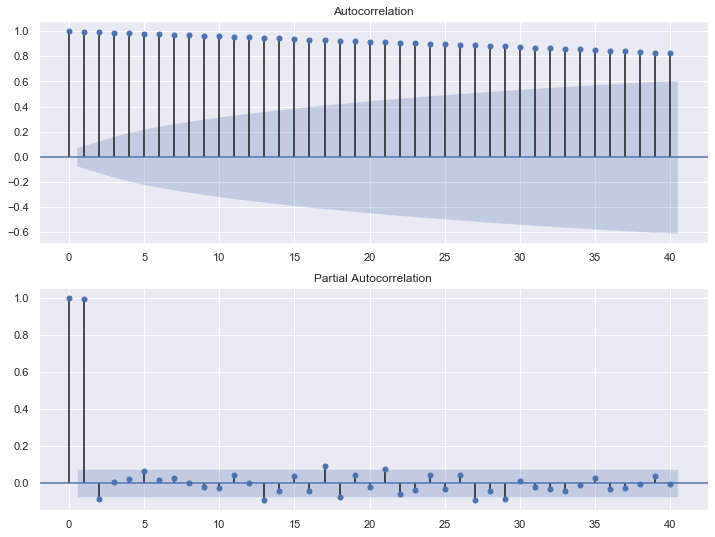

In [67]:
# ACF & PACF der Ursprungszeitreihe
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize = (12, 9))
ax1 = fig.add_subplot(211)
fig = plot_acf(df3['selling'], lags = 40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df3['selling'], lags = 40, ax = ax2)

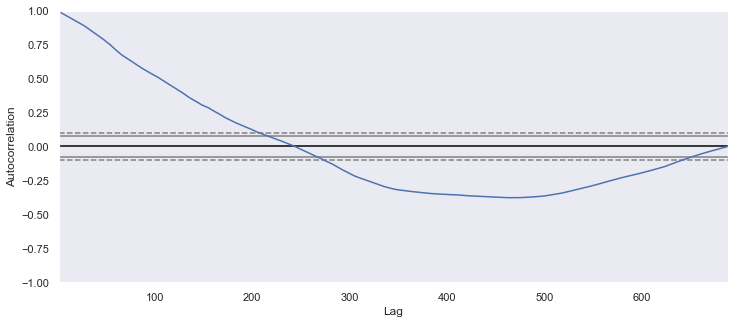

In [68]:
from pandas.plotting import autocorrelation_plot
fig = plt.figure(figsize = (12, 5))
autocorrelation_plot(df3['selling'])
plt.show()

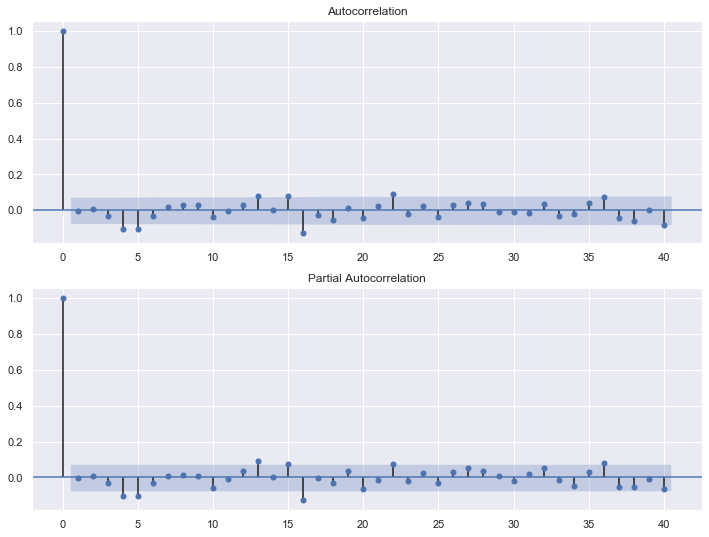

In [69]:
# ACF & PACF der 1. differenzierten Zeitreihe, d.h. d = 1
df3_diff = df3['selling'].diff(periods = 1)
df3_diff.dropna(inplace = True)
fig = plt.figure(figsize = (12, 9))
ax1 = fig.add_subplot(211)
fig = plot_acf(df3_diff, lags = 40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df3_diff, lags = 40, ax = ax2)

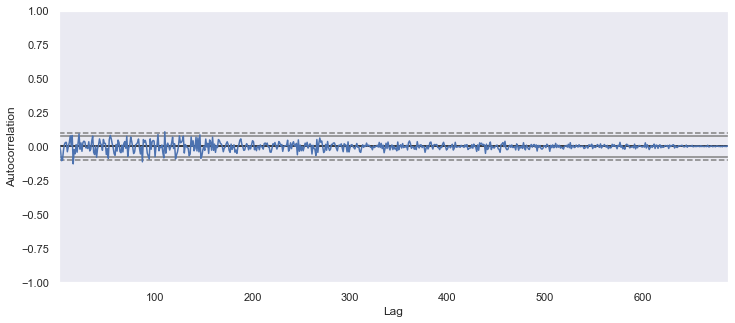

In [70]:
fig = plt.figure(figsize = (12, 5))
autocorrelation_plot(df3_diff)
plt.show()

<b>Steckbrief zur Identifizierung von AR-, MA- und ARMA-Prozessen:</b>

<b>Reiner AR($p$)-Prozess</b>
* ACF $\rho(\tau)$ klingt mit wachsendem $\tau$ ab, eventuell sinusförmig oder alternierend
* PACF $\pi(\tau)$ bricht ab mit $\tau>p$

<b>Reiner MA($q$)-Prozess</b>
* ACF $\rho(\tau)$ bricht ab mit $\tau>q$
* PACF $\pi(\tau)$ klingt mit wachsendem $\tau$ ab, eventuell sinusförmig oder alternierend

<b>ARMA($p,q$)-Prozess</b>
* Beide Funktionen $\rho(\tau)$ und $\pi(\tau)$ klingen mit wachsendem $\tau$ ab, eventuell sinusförmig oder alternierend

---

Mit Hilfe der Funktion <b>auto_arima()</b> aus dem Modul <b>pmdarima</b> können sich die Parameter $p, d, q$ "automatisch" identifizieren lassen. Diese einfache Methode dient nur als erste Orientierung, da dies oft kein gutes Ergebnis für nicht-triviale Zeitreihen liefert.

<b>pmdarima</b> (für py + arima) ist eine statistische Bibliothek, die entwickelt wurde, um die Lücke in den Pythons Zeitreihenanalysefunktionen zu füllen. Dies entspricht etwa Rs auto.arima.

In [71]:
train_selling = dfges['selling'][0:628]
test_selling = dfges['selling'][628:689]

from pmdarima import auto_arima
stepwise_model = auto_arima(train_selling, start_p = 1, start_q = 1, max_p = 7, max_q = 7, d = None, 
                            seasonal = False, trace = True, stepwise = True, 
                            error_action = 'ignore', suppress_warnings = True)

print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=7309.969, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=7138.102, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=7307.971, Time=0.01 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=7078.965, Time=0.08 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=7055.104, Time=0.09 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : AIC=7041.567, Time=0.10 sec
 ARIMA(5,2,0)(0,0,0)[0] intercept   : AIC=7025.651, Time=0.14 sec
 ARIMA(6,2,0)(0,0,0)[0] intercept   : AIC=7006.845, Time=0.42 sec
 ARIMA(7,2,0)(0,0,0)[0] intercept   : AIC=6993.545, Time=0.56 sec
 ARIMA(7,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(6,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(7,2,0)(0,0,0)[0]             : AIC=6991.590, Time=0.27 sec
 ARIMA(6,2,0)(0,0,0)[0]             : AIC=7004.879, T

Laut auto_arima() ist ARIMA (6, 2, 1) die optimale Auswahl für unseren Datensatz. Nun prognostizieren wir sowohl die Werte als auch das Konfindenzintervall für die nächsten 61 Tage:

In [72]:
forecast, conf_int = stepwise_model.predict(n_periods = 61, return_conf_int = True)
forecast = pd.DataFrame(forecast, columns = ['Predicted'])
df_conf = pd.DataFrame(conf_int, columns = ['Upper bound', 'Lower bound'])
df_conf["Index"] = range(628, 689)
df_conf = df_conf.set_index("Index")
forecast["Index"] = range(628, 689)
forecast = forecast.set_index("Index")

Schließlich lassen sich die Ergebnisse mit Konfidenzschranken grafisch darstellen:

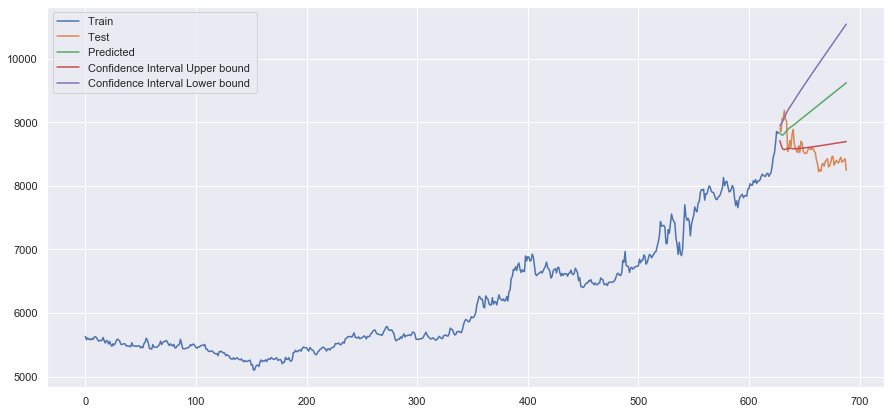

In [73]:
fig = plt.figure(figsize = (15, 7))
plt.plot(train_selling, label = 'Train ')
plt.plot(test_selling, label = 'Test ')
plt.plot(forecast, label = 'Predicted ')
plt.plot(df_conf['Upper bound'], label = 'Confidence Interval Upper bound ')
plt.plot(df_conf['Lower bound'], label = 'Confidence Interval Lower bound ')
plt.legend(loc = 'best')
plt.show()

## 4.2.2. SARIMA = Seasonal ARIMA

SARIMA ist eine Technik von ARIMA, bei der die saisonale Komponente in univariaten Zeitreihendaten behandelt werden kann. Es werden drei neue Hyperparameter hinzugefügt, um AR($P$), I($D$) und MA($Q$) für die Saisonalitätskomponente einer Zeitreihe festzulegen. Das SARIMA-Modell kombiniert sowohl nicht saisonale als auch saisonale Komponenten in einem multiplikativen Modell, welches mit <b>ARIMA$(p, d, q)$x$(P, D, Q)_s$</b> bezeichnet wird.
* <b>$(p, d, q)$</b> sind die oben beschriebenen nicht-saisonalen Parameter
* <b>$(P, D, Q)$</b> folgen der gleichen Definition, werden jedoch auf die saisonale Komponente der Zeitreihe angewendet
* <b>$s$</b> ist die Periodizität der Zeitreihe (1 $\hat{=}$ jährlich (nicht-saisonal); 4 $\hat{=}$ vierteljährlich; 12 $\hat{=}$ monatlich; 52 $\hat{=}$ wöchentlich usw.)

Das SARIMAX-Modell <b>ARIMA$(p, d, q)$x$(P, D, Q)_s(X)$</b> ist ein SARIMA-Modell mit externen Einflussvariablen, wobei $X$ der Vektor exogener Variablen ist.

Bei der Anpassung von Zeitreihendaten an ein saisonales ARIMA-Modell besteht unser erstes Ziel darin, die Werte von ARIMA$(p, d, q)$x$(P, D, Q)_s$ zu ermitteln. Die korrekte Parametrisierung von ARIMA-Modellen kann jedoch ein mühsamer manueller Prozess sein, der Fachwissen und Zeit erfordert.

Wir werden im Folgenden eine <b>"Rastersuche"</b> (grid search) verwenden, um verschiedene Parameterkombinationen iterativ zu untersuchen. Für jede Kombination von Parametern passen wir ein neues Seasonal ARIMA-Modell mit der <b>SARIMAX()</b>-Funktion aus dem Modul <b>statsmodels</b> an und bewerten dessen Gesamtqualität. Sobald wir die gesamte Parameterlandschaft untersucht haben, wird unser optimaler Parametersatz derjenige sein, der die beste Leistung für unsere Kriterien liefert. Beginnen wir mit der Generierung der verschiedenen Parameterkombinationen, die wir bewerten möchten:

In [74]:
from itertools import product
import statsmodels.api as sm 

# Definiere die AR-Parameter p, die Differenzen d und die MA-Parameter q
p = q = range(0, 2)
d = range(1, 2) 

# Erzeuge alle verschiedenen Kombinationen von p-, d- und q-Tripletts
# Verwende itertools.product(), um das kartesische Produkt zu finden
pdq = list(product(p, d, q))

# Erzeuge alle verschiedenen Kombinationen von P-, D- und Q-Tripletts
# Hier setzen wir s = 61, da wir Tagesdaten haben und einen Forecast für die nächsten 61 Tage erstellen möchten
PDQs = [(x[0], x[1], x[2], 61) for x in pdq]

print('Beispiele für Parameterkombinationen für SARIMA:')
print('SARIMAX {} x {}'.format(pdq[1], PDQs[1]))
print('SARIMAX {} x {}'.format(pdq[1], PDQs[2]))
print('SARIMAX {} x {}'.format(pdq[1], PDQs[3]))

Beispiele für Parameterkombinationen für SARIMA:
SARIMAX (0, 1, 1) x (0, 1, 1, 61)
SARIMAX (0, 1, 1) x (1, 1, 0, 61)
SARIMAX (0, 1, 1) x (1, 1, 1, 61)


Bei der Bewertung und dem Vergleich der Modelle werden wir den AIC-Wert verwenden, der bereits in dem Modul statsmodels ausgestattet ist. Der AIC misst, wie gut ein Modell zu den Daten passt und berücksichtigt dabei die Gesamtkomplexität des Modells. Ein Modell, das bei Verwendung vieler Features sehr gut zu den Daten passt, erhält einen höheren AIC-Wert als ein Modell, das weniger Features verwendet, um die gleiche Anpassungsgüte zu erzielen. Daher sind wir daran interessiert, das Modell zu finden, das den niedrigsten AIC-Wert liefert.

Der folgende Codeblock durchläuft Kombinationen von Parametern und verwendet die SARIMAX-Funktion, um sie an das entsprechende Seasonal ARIMA-Modell anzupassen. Hier gibt das Argument order die Parameter $(p, d, q)$ an, während das Argument saisonal_order die saisonale Komponente $(P, D, Q, s)$ angibt. Nach der Anpassung jedes SARIMAX()-Modells wird der jeweilige AIC-Wert ausgegeben.

In [75]:
# Die Daten werden in Trainings- und Testdaten unterteilt
train_selling = dfges['selling'][0:628]
test_selling = dfges['selling'][628:689]

Bei ARIMA sollen/müssen wir skalieren, da man keinen zu hohen Wert eingeben kann. In diesem Fall wird der <b>MinMaxScaler</b> direkt auf den Datensatz angewandt, um die Eingabevariablen zu normalisieren. Wir verwenden die Standardkonfiguration und skalieren die Werte auf den Bereich 0 und 1. Zunächst wird eine MinMaxScaler-Instanz mit Standardhyperparametern definiert. Anschließend können wir die Funktionen fit() und transform() aufrufen und an unseren Datensatz "train_selling" übergeben, um eine transformierte Version des Datasatzes zu erstellen.

In [76]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler().fit(np.array([train_selling]).T)
minmax_values = minmax.transform(np.array([train_selling]).T)

In [77]:
%%time

import warnings
warnings.filterwarnings("ignore") 

lists = []
best_aic = float("inf")
for parameter in pdq:
    for parameter_seasonal in PDQs:
        try:
            model = sm.tsa.statespace.SARIMAX(minmax_values[:, 0],
                                              order = parameter,
                                              seasonal_order = parameter_seasonal,
            # AR-Parameter sollen transformiert werden, 
            # um die Stationarität in der autoregressiven Komponente des Modells zu erzwingen
                                              enforce_stationarity = True,
            # MA-Parameter sollen transformiert werden, 
            # um die Invertierbarkeit in der gleitenden Durchschnitt Komponente des Modells zu erzwingen
                                              enforce_invertibility = True)
            results = model.fit()
            
            # Mit der unteren Code-Zeile können alle Modelle mit den entsprechenden Parametern ausgegeben werden #
            # Zur besseren Übersicht können wir dies auskommentieren # 
            # Wir werden am Ende 5 Modelle mit bestem AIC-Wert ausgeben lassen #
            # print('SARIMAX {} x {} - AIC: {}'.format(parameter, parameter_seasonal, results.aic))
        
        except:
            continue
        aic = results.aic
        if aic < best_aic and aic:
            best_model = results
            best_aic = aic
        lists.append([parameter, parameter_seasonal, results.aic])

Table = pd.DataFrame(lists)
Table.columns = ['Parameter (p, d, q)', 'Parameter (P, D, Q,  s)', 'AIC']
print('Hier sind die Modelle mit dem besten AIC-Wert:\n')
print(Table.sort_values(by = 'AIC', ascending = True).head(5))
print()
print('\033[01m' +'Der beste Akaike Information Criterion ist also AIC = %.6f' % best_aic + '\033[0m')

Hier sind die Modelle mit dem besten AIC-Wert:

   Parameter (p, d, q) Parameter (P, D, Q,  s)          AIC
1            (0, 1, 0)           (0, 1, 1, 61) -2934.978228
9            (1, 1, 0)           (0, 1, 1, 61) -2933.571595
5            (0, 1, 1)           (0, 1, 1, 61) -2933.549774
11           (1, 1, 0)           (1, 1, 1, 61) -2932.919377
3            (0, 1, 0)           (1, 1, 1, 61) -2932.729364

Der beste Akaike Information Criterion ist also AIC = -2934.978228
Wall time: 12min 46s


Mithilfe der Rastersuche haben wir den Parametersatz identifiziert, der das zu unseren Zeitreihendaten "am besten" passende Modell ergibt. Nun werden wir dieses Modell genauer untersuchen.

Die Funktion <b>summary()<b> liefert uns eine Menge an Informationen.

In [78]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  628
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 61)   Log Likelihood                1469.489
Date:                              Sun, 07 Feb 2021   AIC                          -2934.978
Time:                                      17:48:06   BIC                          -2926.301
Sample:                                           0   HQIC                         -2931.592
                                              - 628                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L61      -0.8898      0.061    -14.478      0.000      -1.010      -0.769
sigma2         0.00

Bei der Anpassung von saisonalen ARIMA-Modellen und anderen Modellen ist es sinnvoll, eine Modelldiagnose durchzuführen, um sicherzustellen, dass keine der vom Modell getroffenen Annahmen verletzt wurde. Mit <b>plot_diagnostics()</b> können wir schnell eine Modelldiagnose erstellen und ungewöhnliches Verhalten herausfinden.

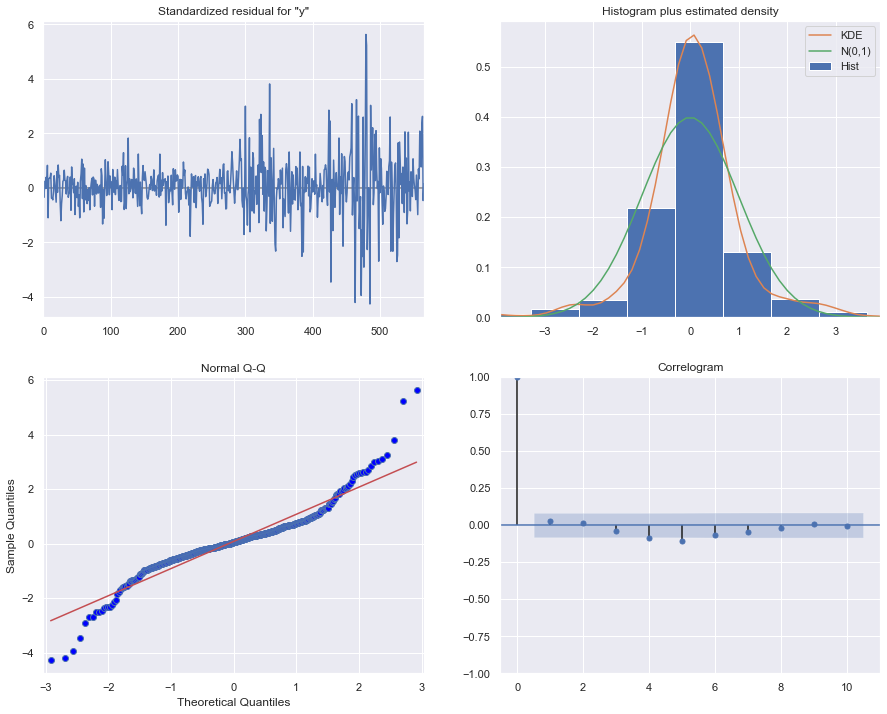

In [79]:
best_model.plot_diagnostics(figsize = (15, 12))
plt.show()

Unser Hauptanliegen besteht darin, sicherzustellen, dass die Residuen unseres Modells unkorreliert und normalverteilt mit Erwartungswert 0 sind. Wenn das SARIMA-Modell diese Eigenschaften nicht erfüllt, ist dies ein guter Hinweis darauf, dass es weiter verbessert werden kann.

In diesem Fall deutet die Modelldiagnose darauf hin, dass die Residuen nur annähernd normalverteilt sind, da:
* In der oberen rechten Grafik sehen wir, dass die rote KDE-Linie (Kernel Density Estimation) nicht mit der grünen Linie der Standardnormalverteilung übereinstimmt. Trotzdem ist der Verlauf der roten Linie glockenförmig, was ein gutes Zeichen für die Normalverteilung ist.
* In dem Quantil-Quantil-Diagramm (Q-Q-Plot) unten links werden die empirischen Quantile der Beobachtungswerte mit den theoretischen Quantilen der Standardnormalverteilung verglichen. Hier sind einige Ausreißer an den Rändern zu finden, aber die meinsten Punkte liegen etwa auf oder sehr nah an der Geraden. Die Residuen können somit einer beliebigen Normalverteilung folgen.
* Das Korrelogramm der ACF zeigt uns, dass die Residuen eine relativ geringe Korrelation mit sich selbst zu einem früheren Zeitpunkt aufweisen.

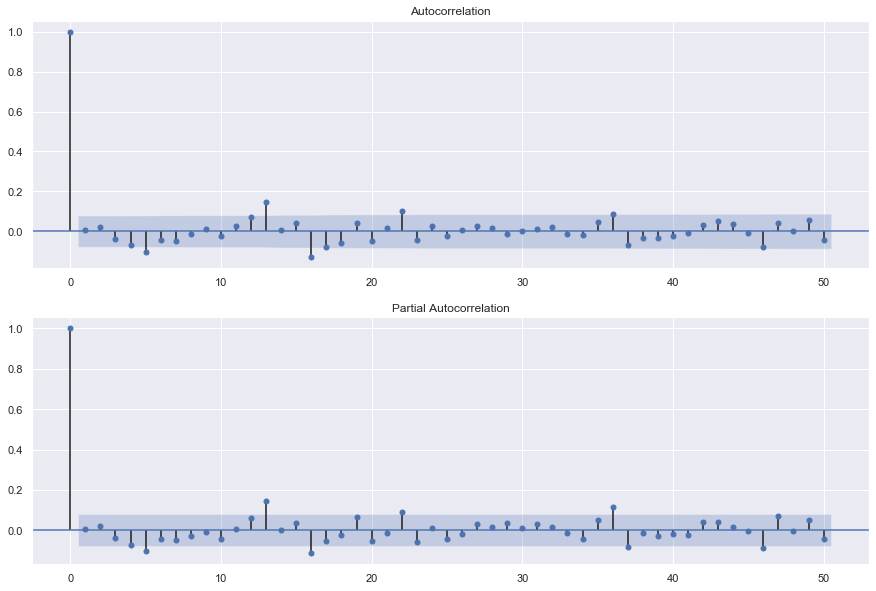

Augmented Dicky-Fuller Test
ADF Test Statistics: -5.805780999475622
p-value: 4.520155648712934e-07
# Lags used: 15
# Observations used: 612
Critical Values:
	1%: -3.4411
	5%: -2.8663
	10%: -2.5693
Reject the null hypothesis!
Data has no unit root and the time series is stationary.


In [80]:
res = best_model.resid
fig, ax = plt.subplots(2, 1, figsize = (15, 10))
fig = sm.graphics.tsa.plot_acf(res, lags = 50, ax = ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags = 50, ax = ax[1])
plt.show()
ADF_Test(res)

Zur Verbesserung der Anpassung können später einige Paramter geändert werden. Zum Beispiel können wir die Rastersuche noch erweitern, da wir eben nur eine begrenzte Anzahl von Parameterkombinationen berücksichtigt haben. Die Erweiterung ist jedoch mit der längeren Laufzeit verbunden.

Mit Hilfe des Modells können nun die Prognosen erstellt werden. Zur Schätzung der Genauigkeit werden wir die vorhergesagten Werte, die unter Verwendung von <b>get_prediction()</b> ausgeben lassen, mit den tatsächlichen Werten der Zeitreihe vergleichen. Das Argument "dynamic = False" stellt sicher, dass wir die Ein-Schritt-Prognosen (one-step-ahead forecasts) erstellen. Dies bedeutet, dass die Prognosen in jedem Zeitpunkt unter Verwendung des vollständigen Verlaufs vom Anfang bis zu diesem Zeitpunkt generiert werden. Da wir auch in die Zukunft prognostizieren, sind diese Prognosen nicht besonders interessant. <b>ARIMA sind also nur für kurzfristige Prognosen (short-term forecasts) nützlich.</b>

In [81]:
# In-sample-Prognose und Out-of-sample-Prognose 
arima_future = best_model.get_prediction(
    start = 0, end = len(train_selling) + 61 - 1,
    dynamic = False
)

# Rückskalierung 
arima_future = minmax.inverse_transform(
    np.expand_dims(arima_future.predicted_mean, axis = 1)
)[:, 0]

In [82]:
from sklearn.linear_model import LinearRegression
linear_regression = LinearRegression().fit(
    np.arange(len(train_selling)).reshape((-1, 1)), train_selling
)
linear_future = linear_regression.predict(
    np.arange(len(train_selling) + 61).reshape((-1, 1))
)

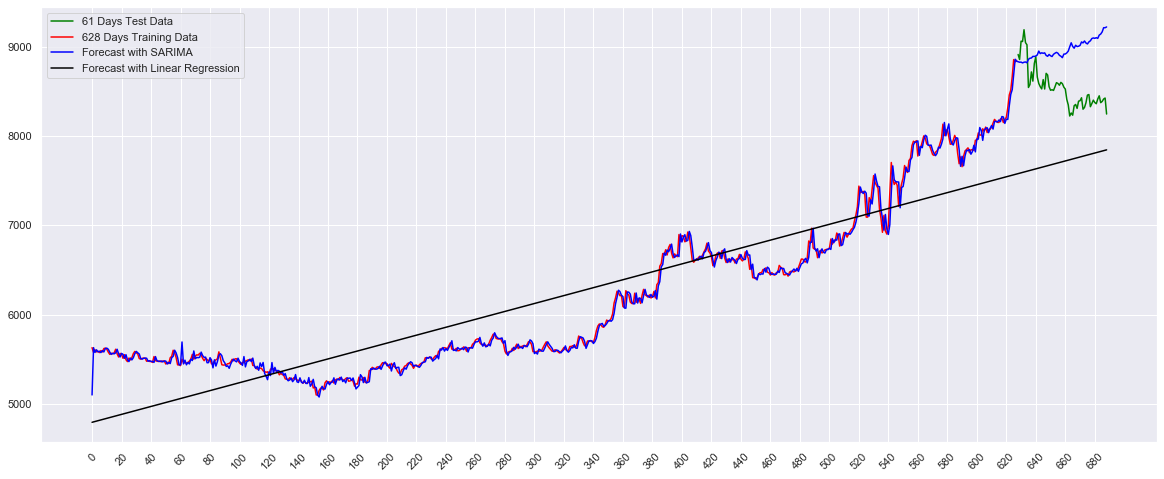

In [83]:
fig, ax = plt.subplots(figsize = (20, 8))
ax.plot(test_selling, label = '61 Days Test Data', color = 'green')
ax.plot(train_selling, label = '628 Days Training Data', color = 'red')
ax.plot(arima_future, label = 'Forecast with SARIMA', color = 'blue')
ax.plot(linear_future, label = 'Forecast with Linear Regression', color = 'black')
plt.xticks(
    np.arange(len(timestamp))[::20],
    np.arange(len(timestamp))[::20],
    rotation = '45',
)
plt.legend(loc = 'best')
plt.show()

     61 Days Test Data  61 Days Predicted Data
628             8911.0             8830.303553
629             8855.0             8824.427341
630             9060.0             8825.821188
631             9056.0             8816.590044
632             9188.0             8824.547518
..                 ...                     ...
684             8372.0             9139.631441
685             8386.0             9163.941017
686             8413.0             9210.743736
687             8424.0             9210.449601
688             8245.0             9219.064964

[61 rows x 2 columns]

MSE = 279691.99308804603


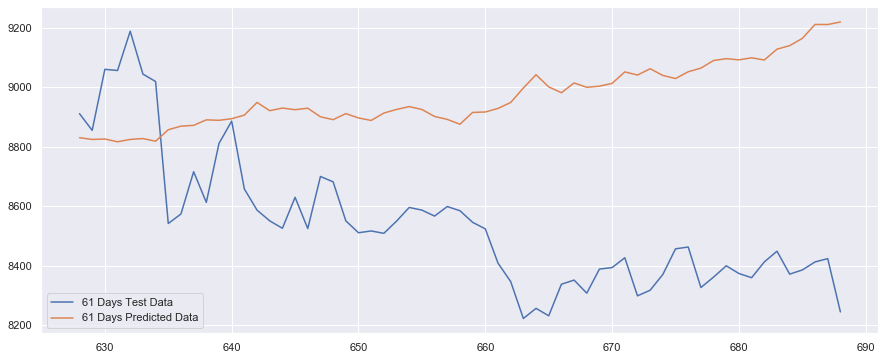

In [84]:
# Out-of-sample-Prognose
pred_61 = arima_future[628: ]

compare = pd.DataFrame({'61 Days Test Data': test_selling, '61 Days Predicted Data': pred_61})
print(compare)
print()
from sklearn.metrics import mean_squared_error
print('MSE = {}'.format(mean_squared_error(test_selling, pred_61)))

compare.plot(figsize = (15, 6))
plt.show()

# 4.3. Predictive Modelling mit LSTM

#### Erstellen der Trainings- und Testsets
Dabei wird darauf geachtet, dass wir immer genau 61 Tage für das Backtesting zur Verfügung haben.

In [85]:
# Zeitreihe ohne Datenmanipulation
train_selling= selling[:628]
test_selling = selling[628:]

future_count = len(test_selling)
print(future_count)

train_selling_2nd_Half = Half2[:284]
test_selling_2nd_Half = Half2[284:]

#print(len(test_selling_2nd_Half))

# Differenzierte Zeitreihe
train_selling_diff = selldiff[:628]
test_selling_diff = selldiff[628:]

train_selling_2nd_Half_diff = sell2[:284]
test_selling_2nd_Half_diff = sell2[284:]

61


In [86]:
import tensorflow as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## 4.3.1. Modelldefinition


<b> LSTM Aufbau </b>
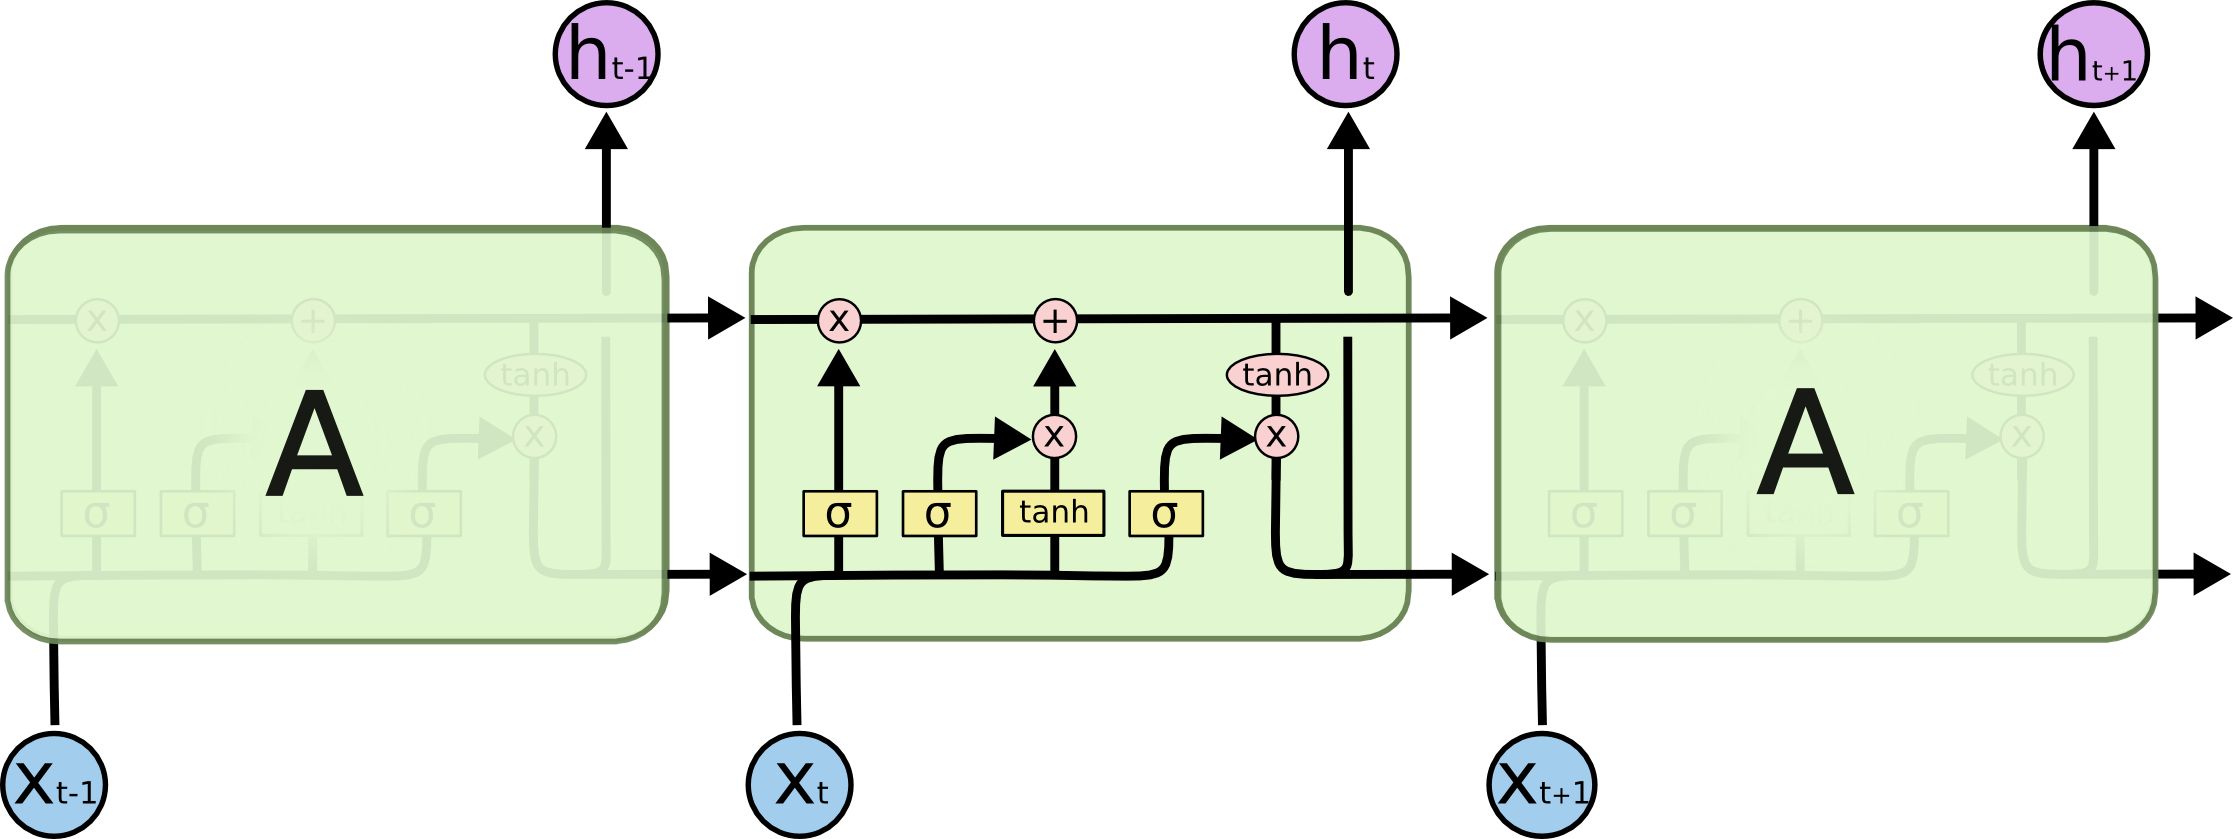
<b> Zellzustand LSTM </b>
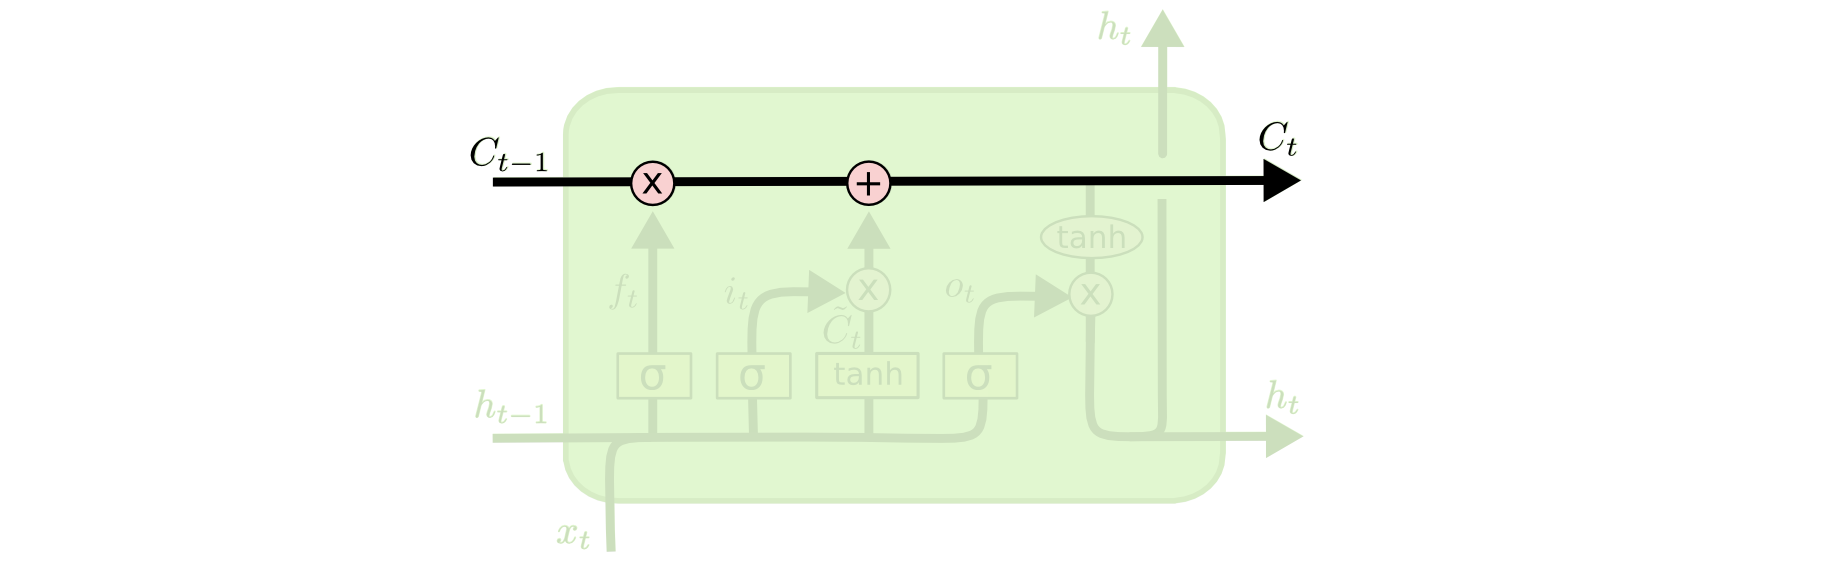
<b> Verlustschicht LSTM </b>
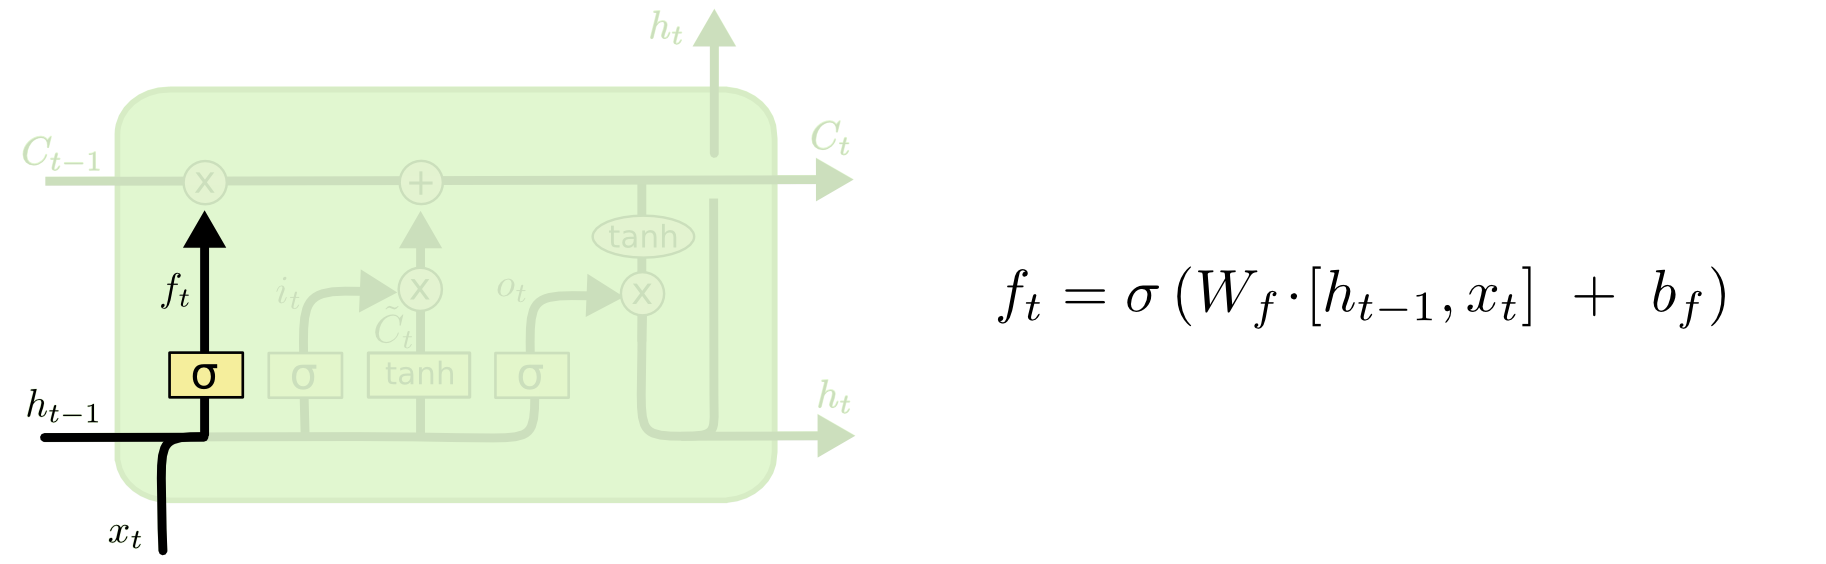
<b> Anderung des Zellzustands LSTM </b>
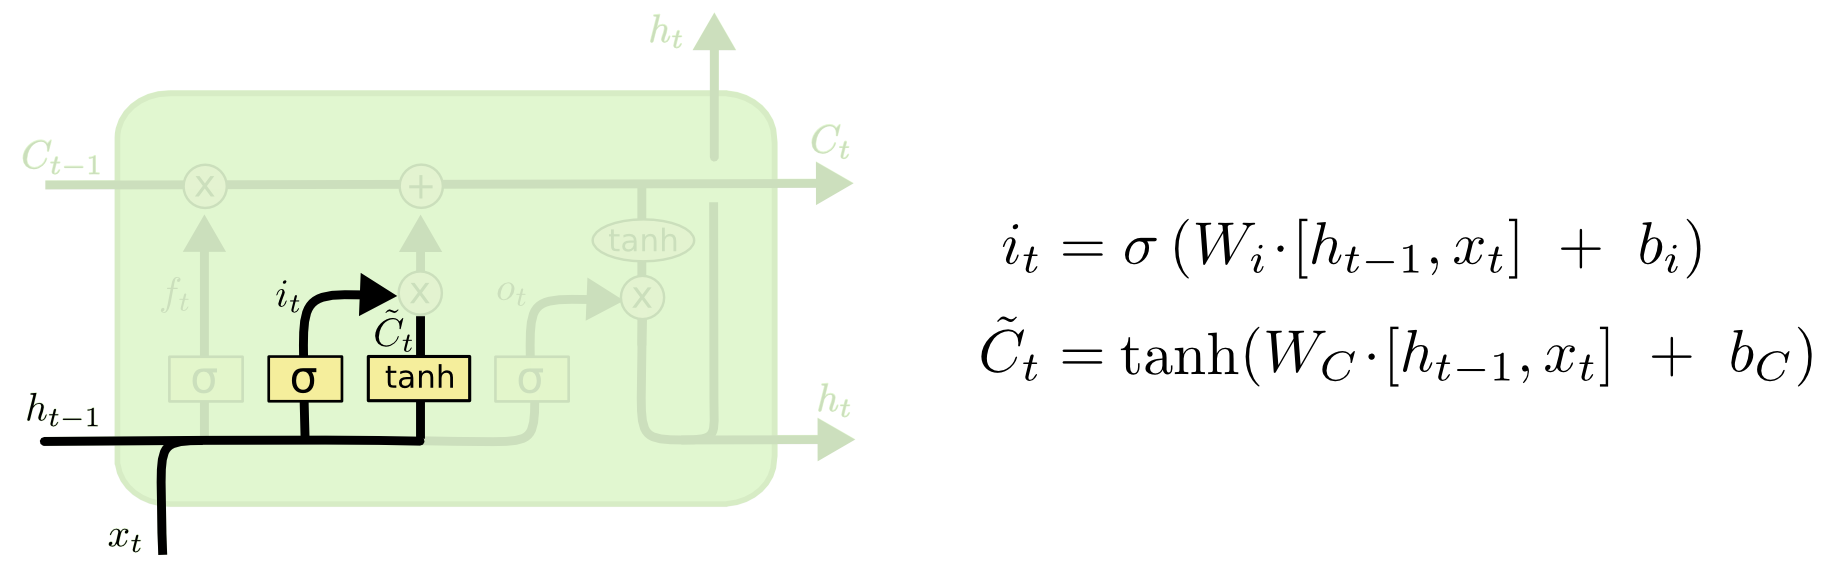
<b> Berechnung neuer Zellzustand LSTM </b>
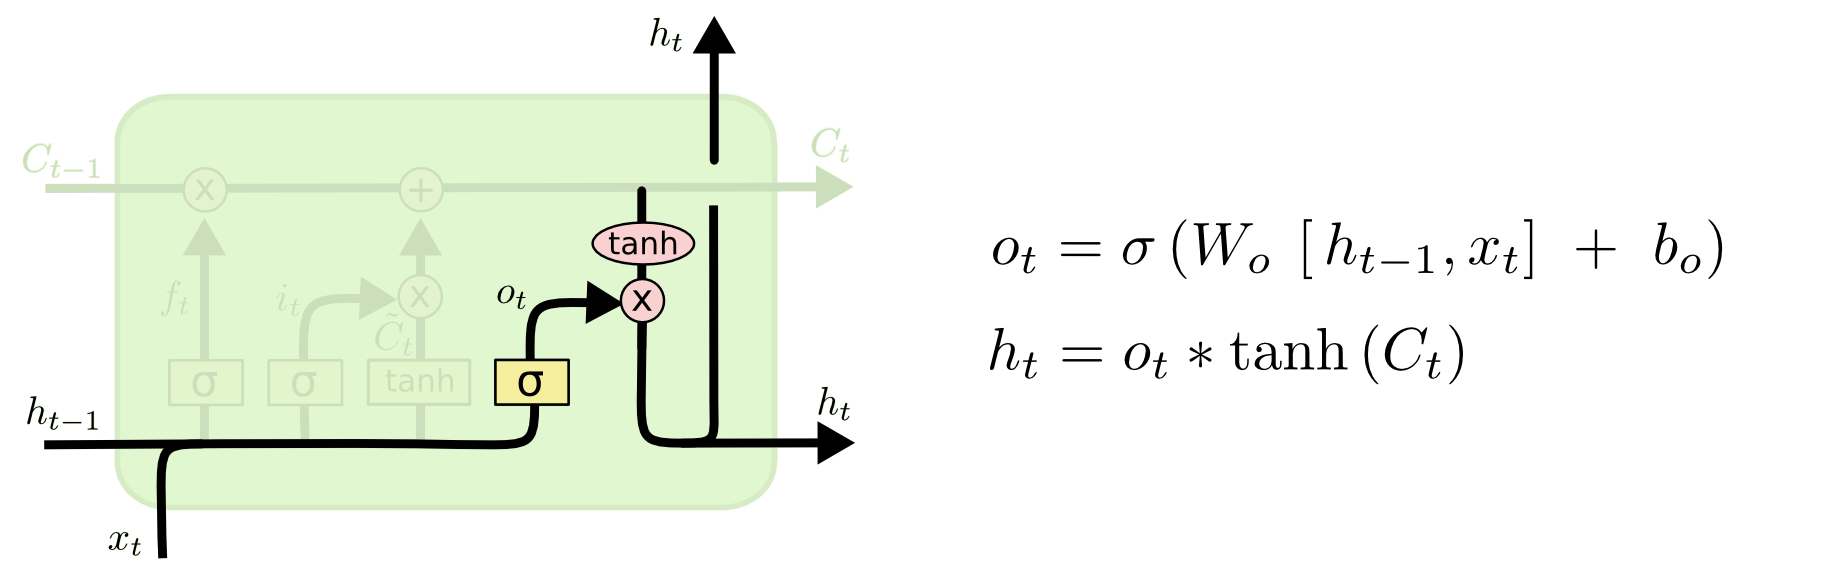
<b> Ausgabe LSTM </b>
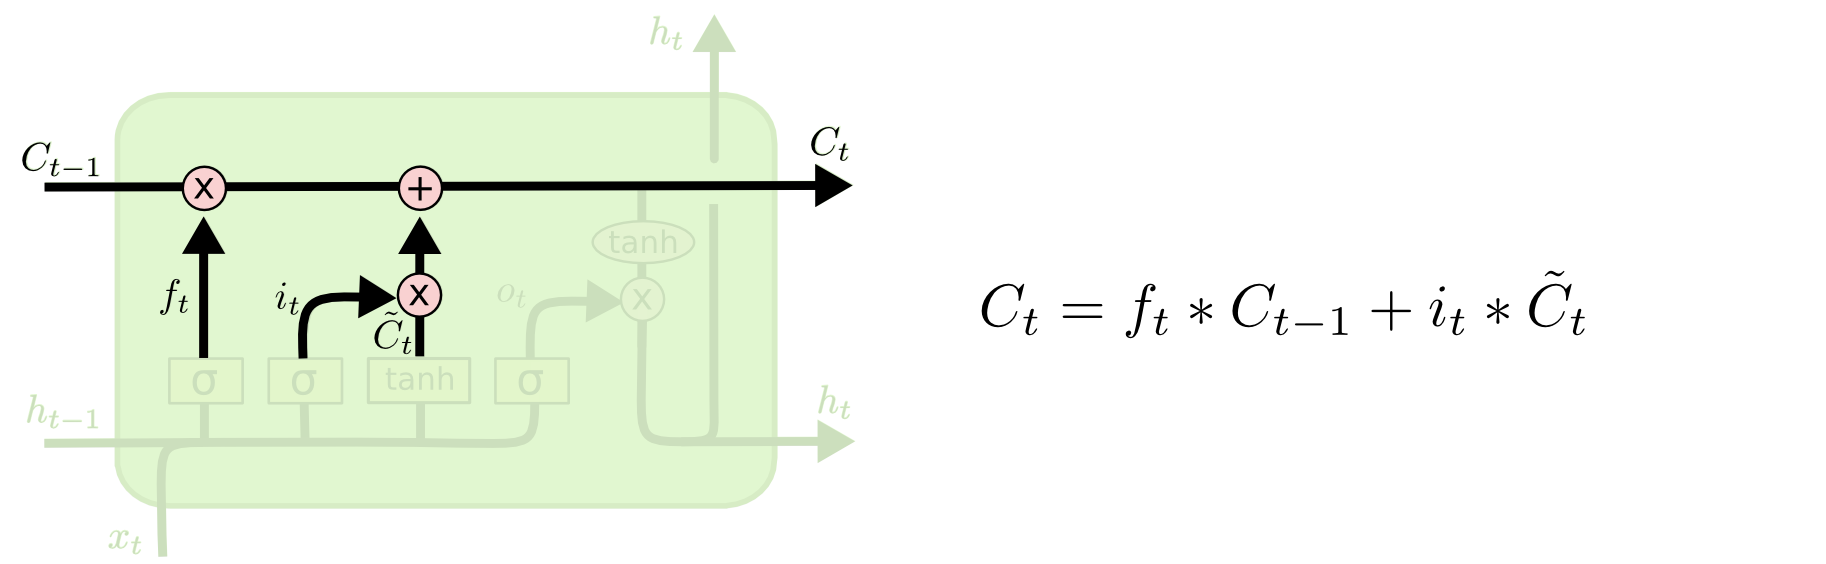



Innerhalb des Machine Learnings ist das <b>Long-Short-Term-Memory (LSTM)</b>
Modell in die _rekurrenten Netze_ einzuordnen. Jenes zeichnet sich dadurch aus, dass sie eine Kettensturktur aufweisen und daher vergangene Daten speichern können. Zudem ergibt sich daraus die Fähigkeit sich an diese Informationen erinnern zu können und für die Vorhersage zu verwenden.
<br>

Allerdings ergibt sich für rekurrente Netze im Allgemeinen das Problem, dass sie schlecht im Umgang mit Abhängigkeiten zwischen Daten sind, die in der Verarbeitungsreihenfolge weit auseinander liegen. <br>

Die Lösung dieser Herausforderung liefern nun die <b>LSTMs</b>, welche im Folgenden betrachtet werden sollen. Diese Netze weisen innerhalb ihrer Kettenstuktur eine vierschichtige Neuronenschicht auf, welche gegenüber den rekurrenten Netzen im Allgemeinen im Vorteil ist, da diese nur genau eine Schicht verwenden.

### Definition

In [87]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        #LSTM wird erstellt
        def lstm_cell(size_layer):
            return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        #mehrere LSTM Zellen werden sequentiell zusammengefügt
        rnn_cells = tf.compat.v1.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size)) # Eingabeschicht X 
        self.Y = tf.placeholder(tf.float32, (None, output_size)) # Ausgabeschicht Y
        #übergibt die Ausgabewerte der LSTM Zellen an die folgenden
        drop = tf.compat.v1.nn.rnn_cell.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        #kreiert ein rekurrentes neuronales Netz
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

### Parameterwahl LSTM

num_layers - Anzahl der mehrschichtigen neuronalen Netze <br>
size_layer - Anzahl der Neuronen im LSTM <br>
epoch - Anzahl der Trainingsläufe <br>
dropout_rate - skaliert, wie viel Information von einem Neuron an das nächste weitergegeben wird <br>
skip - Anzahl der Beobachtungen, die gleichzeitig in einem Trainingslauf verwendet werden

In [88]:
num_layers = 1
size_layer = 128
epoch = 2000
dropout_rate = 0.6
skip = 10

### Datentransformation
Die Zeitreihe wird mittels MinMax Verfahren auf das Intervall [0;1] skaliert.

Neuronale Netze funktionieren dann gewöhnlich besser.

In [89]:
from sklearn.preprocessing import MinMaxScaler
df = pd.DataFrame({'values': train_selling})
minmax = MinMaxScaler().fit(df)
df_log = minmax.transform(df)
df_log = pd.DataFrame(df_log)
print(df_log.head())

df2 = pd.DataFrame({'values': train_selling_2nd_Half})
minmax = MinMaxScaler().fit(df2)
df2_log = minmax.transform(df2)
df2_log = pd.DataFrame(df2_log)
print(df2_log.head())

df3 = pd.DataFrame({'values': train_selling_diff})
minmax = MinMaxScaler().fit(df3)
df3_log = minmax.transform(df3)
df3_log = pd.DataFrame(df3_log)
print(df3_log.head())

df4 = pd.DataFrame({'values': train_selling_2nd_Half_diff})
minmax = MinMaxScaler().fit(df4)
df4_log = minmax.transform(df4)
df4_log = pd.DataFrame(df4_log)
print(df4_log.head())

          0
0  0.141029
1  0.126899
2  0.134631
3  0.128499
4  0.130365
          0
0  0.012358
1  0.009352
2  0.002004
3  0.000000
4  0.010688
          0
0  0.410915
1  0.325843
2  0.457464
3  0.373997
4  0.422151
          0
0  0.410915
1  0.396469
2  0.375602
3  0.401284
4  0.462279


### Modell mit Parametern

In [90]:
modelnn = Model(
    learning_rate = 0.001, 
    num_layers = num_layers, 
    size = df_log.shape[1], 
    size_layer = size_layer, 
    output_size = df_log.shape[1], 
    forget_bias = dropout_rate
)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


## 4.3.2. Modelltraining

### 4.3.2.1 Modell mit kompletter Zeitreihe

#### Modelltraining

In [91]:
%%time

for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, df_log.shape[0] - 1, skip):
        index = min(k + skip, df_log.shape[0] -1)
        batch_x = np.expand_dims(
            df_log.iloc[k : index, :].values, axis = 0
        )
        batch_y = df_log.iloc[k + 1 : index + 1, :].values
        last_state, _, loss = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        total_loss += loss
    total_loss /= ((df_log.shape[0] - 1) / skip)
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 100 avg loss: 0.0009117705303361636
epoch: 200 avg loss: 0.0007309070071404163
epoch: 300 avg loss: 0.0006795396481620584
epoch: 400 avg loss: 0.000817575424311176
epoch: 500 avg loss: 0.0007506513460440876
epoch: 600 avg loss: 0.0007155307788884399
epoch: 700 avg loss: 0.0007222566276313767
epoch: 800 avg loss: 0.0007696651031426191
epoch: 900 avg loss: 0.0007525240047444906
epoch: 1000 avg loss: 0.0006886781404516028
epoch: 1100 avg loss: 0.0007299551506993915
epoch: 1200 avg loss: 0.0006155995853415889
epoch: 1300 avg loss: 0.0006944542508462795
epoch: 1400 avg loss: 0.000661372443626002
epoch: 1500 avg loss: 0.0006266143170426387
epoch: 1600 avg loss: 0.0005776547319412661
epoch: 1700 avg loss: 0.0007293282357983825
epoch: 1800 avg loss: 0.0005760868868943373
epoch: 1900 avg loss: 0.0008602427440352716
epoch: 2000 avg loss: 0.0007722779539464995
Wall time: 9min 34s


#### Erstellung der Vorhersage

In [92]:
df = pd.DataFrame({'values': train_selling})
minmax = MinMaxScaler().fit(df)
df_log = minmax.transform(df)
df_log = pd.DataFrame(df_log)
future_day = future_count

output_predict = np.zeros((df_log.shape[0] + future_day, df_log.shape[1]))
output_predict[0] = df_log.iloc[0]
upper_b = (df_log.shape[0] // skip) * skip
init_value = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (df_log.shape[0] // skip) * skip, skip):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(
                df_log.iloc[k : k + skip], axis = 0
            ),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[k + 1 : k + skip + 1] = out_logits

if upper_b < df_log.shape[0]:
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[upper_b:], axis = 0),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[upper_b + 1 : df_log.shape[0] + 1] = out_logits
    df_log.loc[df_log.shape[0]] = out_logits[-1]
    future_day = future_day - 1
    
for i in range(future_day):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[-skip:], axis = 0),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[df_log.shape[0]] = out_logits[-1]
    df_log.loc[df_log.shape[0]] = out_logits[-1]

#### Rücktransformation der Werte & Plot

In [93]:
df_log = minmax.inverse_transform(output_predict)

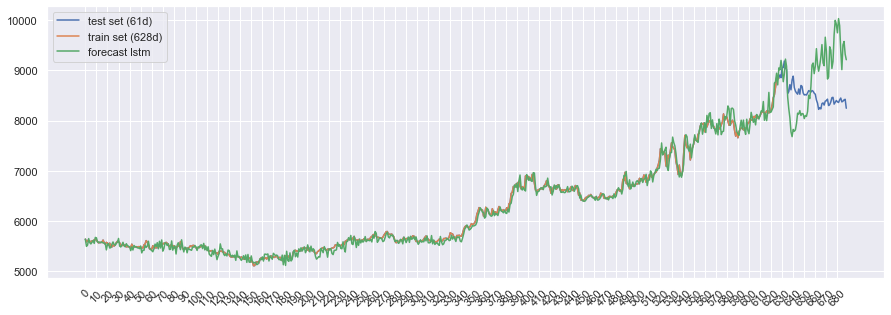

In [94]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(selling, label = 'test set (61d)')
ax.plot(train_selling, label = 'train set (628d)')
ax.plot(df_log, label='forecast lstm')
plt.xticks(
    np.arange(len(timestamp))[::10],
    np.arange(len(timestamp))[::10],
    rotation = '45',
)
plt.legend()
plt.show()

### 4.3.2.2 Modell mit der zweiten Hälften der Daten

#### Modelltraining

In [95]:
for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, df2_log.shape[0] - 1, skip):
        index = min(k + skip, df2_log.shape[0] -1)
        batch_x = np.expand_dims(
            df2_log.iloc[k : index, :].values, axis = 0
        )
        batch_y = df2_log.iloc[k + 1 : index + 1, :].values
        last_state, _, loss = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        total_loss += loss
    total_loss /= ((df2_log.shape[0] - 1) / skip)
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 100 avg loss: 0.001762345337696446
epoch: 200 avg loss: 0.0011334710770600077
epoch: 300 avg loss: 0.0021780731008172547
epoch: 400 avg loss: 0.0014048692010414652
epoch: 500 avg loss: 0.0014878669270320857
epoch: 600 avg loss: 0.0017198920054542224
epoch: 700 avg loss: 0.0020494370533288343
epoch: 800 avg loss: 0.0016904304354441724
epoch: 900 avg loss: 0.001821999469781854
epoch: 1000 avg loss: 0.002603139653234239
epoch: 1100 avg loss: 0.002414191768228244
epoch: 1200 avg loss: 0.0014887011523379914
epoch: 1300 avg loss: 0.0014934705147871834
epoch: 1400 avg loss: 0.0013704023267596618
epoch: 1500 avg loss: 0.001980658309400911
epoch: 1600 avg loss: 0.002260755018624
epoch: 1700 avg loss: 0.0016655436883163852
epoch: 1800 avg loss: 0.0019040295733681915
epoch: 1900 avg loss: 0.0014542632278831604
epoch: 2000 avg loss: 0.0011135961234326024


#### Erstellung der Vorhersage

In [96]:
df2 = pd.DataFrame({'values': train_selling_2nd_Half})
minmax = MinMaxScaler().fit(df2)
df2_log = minmax.transform(df2)
df2_log = pd.DataFrame(df2_log)
future_day = future_count

output_predict = np.zeros((df2_log.shape[0] + future_day, df2_log.shape[1]))
output_predict[0] = df2_log.iloc[0]
upper_b = (df2_log.shape[0] // skip) * skip
init_value = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (df2_log.shape[0] // skip) * skip, skip):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(
                df2_log.iloc[k : k + skip], axis = 0
            ),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[k + 1 : k + skip + 1] = out_logits

if upper_b < df2_log.shape[0]:
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df2_log.iloc[upper_b:], axis = 0),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[upper_b + 1 : df2_log.shape[0] + 1] = out_logits
    df2_log.loc[df2_log.shape[0]] = out_logits[-1]
    future_day = future_day - 1
    
for i in range(future_day):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df2_log.iloc[-skip:], axis = 0),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[df2_log.shape[0]] = out_logits[-1]
    df2_log.loc[df2_log.shape[0]] = out_logits[-1]

#### Rücktransformation der Werte & Plot

In [97]:
df2_log = minmax.inverse_transform(output_predict)

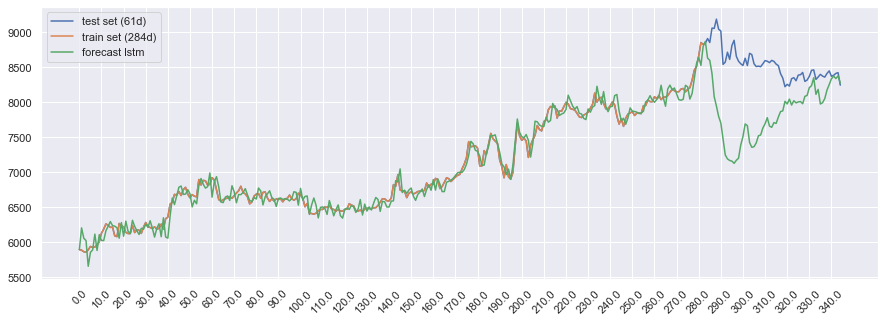

In [98]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(Half2, label = 'test set (61d)')
ax.plot(train_selling_2nd_Half, label = 'train set (284d)')
ax.plot(df2_log, label='forecast lstm')
plt.xticks(
    np.arange(len(timestamp)/2)[::10],
    np.arange(len(timestamp)/2)[::10],
    rotation = '45',
)
plt.legend()
plt.show()

### 4.3.2.3 Modell mit differenziereter Zeitreihe

#### Modelltraining

In [99]:
%%time

for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, df3_log.shape[0] - 1, skip):
        index = min(k + skip, df3_log.shape[0] -1)
        batch_x = np.expand_dims(
            df3_log.iloc[k : index, :].values, axis = 0
        )
        batch_y = df3_log.iloc[k + 1 : index + 1, :].values
        last_state, _, loss = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        total_loss += loss
    total_loss /= ((df3_log.shape[0] - 1) / skip)
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 100 avg loss: 0.00930908740891004
epoch: 200 avg loss: 0.009084944796163227
epoch: 300 avg loss: 0.008178312496499023
epoch: 400 avg loss: 0.007042654836773159
epoch: 500 avg loss: 0.0059956450021247925
epoch: 600 avg loss: 0.00527711298396184
epoch: 700 avg loss: 0.004697563026421235
epoch: 800 avg loss: 0.0037618665035035713
epoch: 900 avg loss: 0.003217886713744873
epoch: 1000 avg loss: 0.004378700700545449
epoch: 1100 avg loss: 0.002601977571510105
epoch: 1200 avg loss: 0.002348670170403292
epoch: 1300 avg loss: 0.0021703331030354174
epoch: 1400 avg loss: 0.0021314525105426032
epoch: 1500 avg loss: 0.002310221774434519
epoch: 1600 avg loss: 0.0018158213077061043
epoch: 1700 avg loss: 0.0018742369108464259
epoch: 1800 avg loss: 0.002702967177607131
epoch: 1900 avg loss: 0.0013031349168344736
epoch: 2000 avg loss: 0.0015369807208937992
Wall time: 9min 34s


#### Erstellung der Vorhersage

In [100]:
df3 = pd.DataFrame({'values': train_selling_diff})
minmax = MinMaxScaler().fit(df3)
df3_log = minmax.transform(df3)
df3_log = pd.DataFrame(df3_log)
future_day = future_count

output_predict = np.zeros((df3_log.shape[0] + future_day, df3_log.shape[1]))
output_predict[0] = df3_log.iloc[0]
upper_b = (df3_log.shape[0] // skip) * skip
init_value = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (df3_log.shape[0] // skip) * skip, skip):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(
                df3_log.iloc[k : k + skip], axis = 0
            ),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[k + 1 : k + skip + 1] = out_logits

if upper_b < df3_log.shape[0]:
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df3_log.iloc[upper_b:], axis = 0),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[upper_b + 1 : df3_log.shape[0] + 1] = out_logits
    df3_log.loc[df3_log.shape[0]] = out_logits[-1]
    future_day = future_day - 1
    
for i in range(future_day):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df3_log.iloc[-skip:], axis = 0),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[df3_log.shape[0]] = out_logits[-1]
    df3_log.loc[df3_log.shape[0]] = out_logits[-1]


#### Rücktransformation der Werte & Plot

In [101]:
df3_log = minmax.inverse_transform(output_predict)

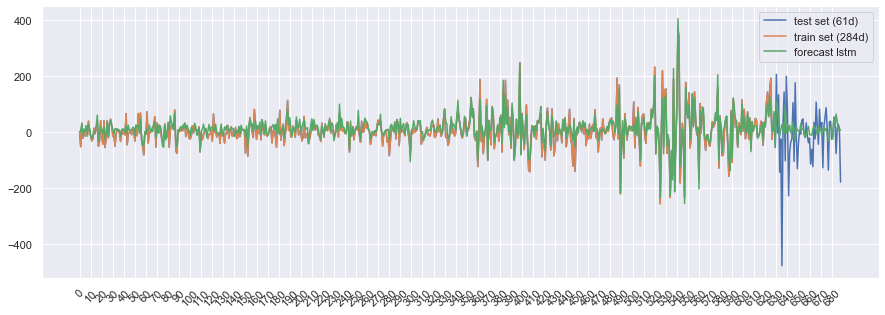

In [102]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(selldiff, label = 'test set (61d)')
ax.plot(train_selling_diff, label = 'train set (284d)')
ax.plot(df3_log, label='forecast lstm')
plt.xticks(
    np.arange(len(timestamp))[::10],
    np.arange(len(timestamp))[::10],
    rotation = '45',
)
plt.legend()
plt.show()

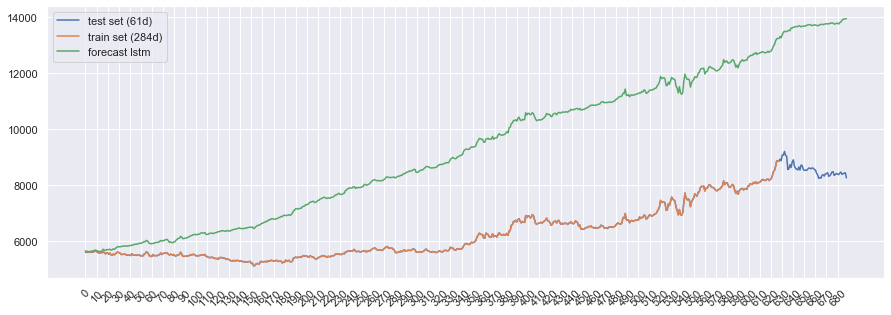

In [103]:
df3_cumsum = np.cumsum(df3_log) + selling[1]

fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(selling, label = 'test set (61d)')
ax.plot(train_selling , label = 'train set (284d)')
ax.plot(df3_cumsum, label = "forecast lstm")
plt.xticks(
    np.arange(len(timestamp))[::10],
    np.arange(len(timestamp))[::10],
    rotation = '45',
)
plt.legend()
plt.show()

### 4.3.2.3 Modell mit differenziereter Zeitreihe (zweite Hälfte der Daten)

#### Modelltraining

In [104]:
for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, df4_log.shape[0] - 1, skip):
        index = min(k + skip, df4_log.shape[0] -1)
        batch_x = np.expand_dims(
            df4_log.iloc[k : index, :].values, axis = 0
        )
        batch_y = df4_log.iloc[k + 1 : index + 1, :].values
        last_state, _, loss = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        total_loss += loss
    total_loss /= ((df4_log.shape[0] - 1) / skip)
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 100 avg loss: 0.0016152399150710618
epoch: 200 avg loss: 0.0022763507854104592
epoch: 300 avg loss: 0.0014486796302431305
epoch: 400 avg loss: 0.003028377027138936
epoch: 500 avg loss: 0.0018563478300265652
epoch: 600 avg loss: 0.002225479581055985
epoch: 700 avg loss: 0.004748205745645368
epoch: 800 avg loss: 0.002415028000464367
epoch: 900 avg loss: 0.002246855925966067
epoch: 1000 avg loss: 0.0011717423927466723
epoch: 1100 avg loss: 0.0021769500637012318
epoch: 1200 avg loss: 0.0012302262027329986
epoch: 1300 avg loss: 0.001452097342159951
epoch: 1400 avg loss: 0.0023082236355407553
epoch: 1500 avg loss: 0.0022690647442960067
epoch: 1600 avg loss: 0.002072094114869175
epoch: 1700 avg loss: 0.009692864983701295
epoch: 1800 avg loss: 0.003369790647925921
epoch: 1900 avg loss: 0.002861471422791626
epoch: 2000 avg loss: 0.0030347795957697773


#### Erstellung der Vorhersage

In [105]:
df4 = pd.DataFrame({'values': train_selling_2nd_Half_diff})
minmax = MinMaxScaler().fit(df4)
df4_log = minmax.transform(df4)
df4_log = pd.DataFrame(df4_log)
future_day = future_count

output_predict = np.zeros((df4_log.shape[0] + future_day, df4_log.shape[1]))
output_predict[0] = df4_log.iloc[0]
upper_b = (df4_log.shape[0] // skip) * skip
init_value = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (df4_log.shape[0] // skip) * skip, skip):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(
                df4_log.iloc[k : k + skip], axis = 0
            ),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[k + 1 : k + skip + 1] = out_logits

if upper_b < df4_log.shape[0]:
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df4_log.iloc[upper_b:], axis = 0),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[upper_b + 1 : df4_log.shape[0] + 1] = out_logits
    df4_log.loc[df4_log.shape[0]] = out_logits[-1]
    future_day = future_day - 1
    
for i in range(future_day):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df4_log.iloc[-skip:], axis = 0),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[df4_log.shape[0]] = out_logits[-1]
    df4_log.loc[df4_log.shape[0]] = out_logits[-1]

#### Rücktransformation der Werte & Plot

In [106]:
df4_log = minmax.inverse_transform(output_predict)

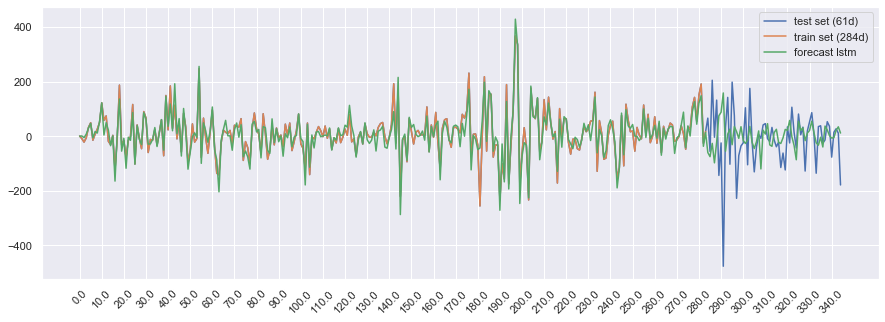

In [107]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(sell2, label = 'test set (61d)')
ax.plot(train_selling_2nd_Half_diff, label = 'train set (284d)')
ax.plot(df4_log, label='forecast lstm')
plt.xticks(
    np.arange(len(timestamp)/2)[::10],
    np.arange(len(timestamp)/2)[::10],
    rotation = '45',
)
plt.legend()
plt.show()

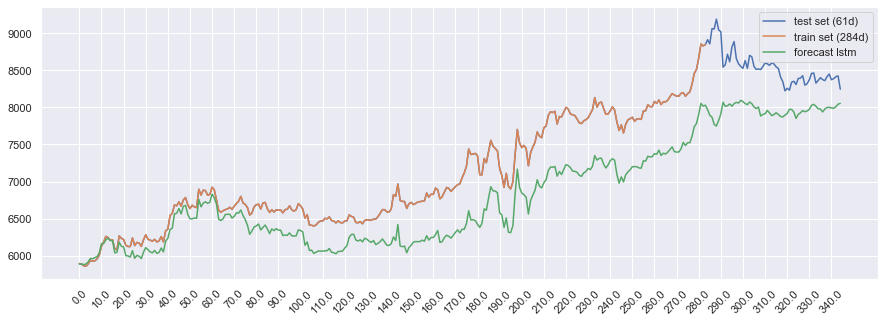

In [108]:
df4_cumsum = np.cumsum(df4_log) + df2.values[1]

fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(Half2, label = 'test set (61d)')
ax.plot(train_selling_2nd_Half , label = 'train set (284d)')
ax.plot(df4_cumsum, label = "forecast lstm")
plt.xticks(
    np.arange(len(timestamp)/ 2)[::10],
    np.arange(len(timestamp)/ 2)[::10],
    rotation = '45',
)
plt.legend()
plt.show()

# 5. Auswertung

<b>Bewertungskennzahlen</b>
* <b>Der mittlere quadratische Fehler (MSE)</b> gibt an, wie nah eine Regressionslinie an einer Reihe von Punkten liegt. Dazu werden die Abstände von den Punkten zur Regressionslinie (diese Abstände sind die Fehler) genommen und quadriert. Je näher der Fehler an Null liegt, desto besser ist das Modell.
\begin{align*}
MSE=\frac{1}{n}\sum_{i=1}^n(X_i - \widehat{X_i})^2
\end{align*}
* <b>Der Root Mean Square Error (RMSE)</b> ist eine quadratische Bewertungsregel, die die durchschnittliche Größe des Fehlers misst. Es ist die Quadratwurzel des Durchschnitts der quadratischen Unterschiede zwischen Vorhersage und tatsächlicher Beobachtung. Je näher der Fehler an Null liegt, desto besser ist das Modell.
\begin{align*}
RMSE= \sqrt{MSE}
\end{align*}
* <b>Der mittlere absolute Fehler (MAE)</b> misst auch die durchschnittliche Größe der Fehler in einer Reihe von Vorhersagen, ohne deren Richtung zu berücksichtigen. Je näher der Fehler an Null liegt, desto besser ist das Modell.
\begin{align*}
MAE=\frac{1}{n}\sum_{i=1}^n\left| X_i - \widehat{X_i}\right|
\end{align*}
* <b>Der mittlere absolute prozentuale Fehler (MAPE)</b> ist ein statistisches Maß für die Genauigkeit eines Prognosesystems. Es ist ein Maß in Prozent und wird hauptsächlich für Zeitreihenprognosen verwendet. Je näher der Fehler an Null liegt, desto besser ist das Modell.
\begin{align*}
MAPE=\frac{1}{n}\sum_{i=1}^n\left|\frac{X_i - \widehat{X_i}}{X_i}\right|\cdot 100\%
\end{align*}
* <b>Das Bestimmtheitsmaß</b>, auch Determinationskoeffizient, bezeichnet mit $R^2$, bestimmt den Anteil der Varianz in der abhängigen Variablen, der durch die unabhängige Variable erklärt werden kann. Je näher das Bestimmtheitsmaß am Wert Eins liegt, desto höher ist die "Bestimmtheit" bzw. "Güte" der Anpassung.
* <b>Die Korrelation nach Bravais-Pearson</b> berechnet den linearen Zusammenhang zweier intervallskalierter Variablen. Der Korrelationskoeffizient $r\in[-1;1]$, wobei 1 einen perfekt positiven und -1 eine perfekt negative Korrelation impliziert.
* <b>Der Spearman-Korrelationskoeffizient $r_S$</b> wird auch Rangkorrelationskoeffizient genannt und hat einen entscheidenden Unterschied zum klassischen Pearson-Korrelationskoeffizienten $r$: Die Korrelation wird nicht zwischen den Datenpunkten selbst, sondern zwischen ihren Rängen berechnet.

In [109]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def calculate_distance(real, predict):
    mse = mean_squared_error(real, predict) # mse = ((real - predict) ** 2).mean()
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(real, predict)
    mape = np.mean(np.abs((real - predict) / real)) * 100
    mse = mse.round(3)
    rmse = rmse.round(3)
    mae = mae.round(3)
    return {
        'MSE': mse, 
        'RMSE': rmse, 
        'MAE': mae,
        'MAPE': mape
    }

In [110]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr

def calculate_accuracy(real, predict):
    r2 = r2_score(real, predict)
    if r2 < 0:
        r2 = 0

    def change_percentage(val): 
        if val > 0:
            return val
        else:
            return val + 1

    pearson = pearsonr(real, predict)[0]
    spearman = spearmanr(real, predict)[0]
    pearson = change_percentage(pearson)
    spearman = change_percentage(spearman)
    pearson = pearson.round(5)
    spearman = spearman.round(5)
    return {
        'R-Squared': r2 * 100,
        'Pearson': pearson * 100,
        'Spearman': spearman * 100
    }

## 5.1. Validierung basierend auf den Trainingsdaten

#### Linear Regression

In [111]:
linear_cuta = linear_future[: len(train_selling)]
linear_cutdiffa = linear_diffcumsum[: len(train_sellingdiff)]

In [112]:
distlineara = calculate_distance(train_selling, linear_cuta)
distlineardiffa = calculate_distance(train_selling, linear_cutdiffa)
print(distlineara)
print(distlineardiffa)

{'MSE': 162772.903, 'RMSE': 403.451, 'MAE': 350.469, 'MAPE': 5.711804772912216}
{'MSE': 63104.299, 'RMSE': 251.206, 'MAE': 191.951, 'MAPE': 2.9588148606275193}


In [113]:
acclineara = calculate_accuracy(train_selling, linear_cuta)
acclineardiffa = calculate_accuracy(train_selling, linear_cutdiffa)
print(acclineara)
print(acclineardiffa)

{'R-Squared': 79.8409346754025, 'Pearson': 89.354, 'Spearman': 89.77199999999999}
{'R-Squared': 92.18467158451602, 'Pearson': 97.751, 'Spearman': 96.993}


#### ARIMA

In [114]:
arima_cuta = arima_future[: len(train_selling)]

In [115]:
distarimaa = calculate_distance(train_selling, arima_cuta)

In [116]:
accarimaa = calculate_accuracy(train_selling, arima_cuta)

In [117]:
print(distarimaa)
print(accarimaa)

{'MSE': 4412.811, 'RMSE': 66.429, 'MAE': 43.359, 'MAPE': 0.6806515195650754}
{'R-Squared': 99.45348309823504, 'Pearson': 99.72800000000001, 'Spearman': 99.105}


#### LSTM

In [118]:
lstm_cut1a = df_log[: len(train_selling)]
lstm_cut2a = df2_log[: len(train_selling_2nd_Half )]
lstm_cut3a = df3_cumsum[: len(train_selling)]
lstm_cut4a = df4_cumsum[: len(train_selling_2nd_Half )]

In [119]:
distlstm1a = calculate_distance(list(train_selling), lstm_cut1a)
distlstm2a = calculate_distance(train_selling_2nd_Half , lstm_cut2a)
distlstm3a = calculate_distance(train_selling, lstm_cut3a)
distlstm4a = calculate_distance(train_selling_2nd_Half , lstm_cut4a)
print(distlstm1a)
print(distlstm2a)
print(distlstm3a)
print(distlstm4a)

{'MSE': 8255.508, 'RMSE': 90.86, 'MAE': 66.93, 'MAPE': 15.378290130801442}
{'MSE': 11056.895, 'RMSE': 105.152, 'MAE': 81.586, 'MAPE': 10.989679431998098}
{'MSE': 9722608.832, 'RMSE': 3118.11, 'MAE': 2726.683, 'MAPE': 42.19450303207437}
{'MSE': 260836.256, 'RMSE': 510.721, 'MAE': 443.279, 'MAPE': 6.077357763268112}


In [120]:
acclstm1a = calculate_accuracy(train_selling, lstm_cut1a.ravel())
acclstm2a = calculate_accuracy(train_selling_2nd_Half, lstm_cut2a.ravel())
acclstm3a = calculate_accuracy(train_selling, lstm_cut3a)
acclstm4a = calculate_accuracy(train_selling_2nd_Half , lstm_cut4a)
print(acclstm1a)
print(acclstm2a)
print(acclstm3a)
print(acclstm4a)

{'R-Squared': 98.97757349454885, 'Pearson': 99.523, 'Spearman': 98.271}
{'R-Squared': 97.70155106458961, 'Pearson': 98.85199999999999, 'Spearman': 97.444}
{'R-Squared': 0, 'Pearson': 91.987, 'Spearman': 90.00200000000001}
{'R-Squared': 45.77873529343612, 'Pearson': 95.92500000000001, 'Spearman': 92.172}


## 5.2. Validierung basierend auf den Testdaten

#### Linear Regression

In [121]:
linear_cutb = linear_future[len(train_selling) :]
linear_cutdiffb = linear_diffcumsum[len(train_sellingdiff) :]

In [122]:
distlinearb = calculate_distance(test_selling, linear_cutb)
distlineardiffb = calculate_distance(test_selling, linear_cutdiffb)
print(distlinearb)
print(distlineardiffb)

{'MSE': 768182.178, 'RMSE': 876.46, 'MAE': 827.662, 'MAPE': 9.614465988632013}
{'MSE': 867506.454, 'RMSE': 931.4, 'MAE': 824.076, 'MAPE': 9.771713778576677}


In [123]:
acclinearb = calculate_accuracy(test_selling, linear_cutb)
acclineardiffb = calculate_accuracy(test_selling, linear_cutdiffb)
print(acclinearb)
print(acclineardiffb)

{'R-Squared': 0, 'Pearson': 19.792, 'Spearman': 18.471}
{'R-Squared': 0, 'Pearson': 20.348, 'Spearman': 18.471}


#### ARIMA

In [124]:
arima_cutb = arima_future[len(train_selling) :]

In [125]:
distarimab = calculate_distance(test_selling, arima_cutb)

In [126]:
accarimab = calculate_accuracy(test_selling, arima_cutb)

In [127]:
print(distarimab)
print(accarimab)

{'MSE': 279691.993, 'RMSE': 528.859, 'MAE': 474.355, 'MAPE': 5.61692487857801}
{'R-Squared': 0, 'Pearson': 25.807000000000002, 'Spearman': 19.111}


#### LSTM

In [128]:
lstm_cut1b = df_log[len(train_selling) :]
lstm_cut2b = df2_log[len(train_selling_2nd_Half ) :]
lstm_cut3b = df3_cumsum[len(train_selling) :]
lstm_cut4b = df4_cumsum[len(train_selling_2nd_Half ) :]

In [129]:
distlstm1b = calculate_distance(list(test_selling), lstm_cut1b)
distlstm2b = calculate_distance(test_selling_2nd_Half , lstm_cut2b)
distlstm3b = calculate_distance(test_selling, lstm_cut3b)
distlstm4b = calculate_distance(test_selling_2nd_Half , lstm_cut4b)
print(distlstm1b)
print(distlstm2b)
print(distlstm3b)
print(distlstm4b)

{'MSE': 677479.576, 'RMSE': 823.091, 'MAE': 707.518, 'MAPE': 7.647497979903413}
{'MSE': 718530.901, 'RMSE': 847.662, 'MAE': 693.967, 'MAPE': 8.19462425021553}
{'MSE': 26532126.172, 'RMSE': 5150.934, 'MAE': 5139.716, 'MAPE': 60.32750627178933}
{'MSE': 392673.574, 'RMSE': 626.637, 'MAE': 573.445, 'MAPE': 6.648510960567119}


In [130]:
acclstm1b = calculate_accuracy(test_selling, lstm_cut1b.ravel())
acclstm2b = calculate_accuracy(test_selling_2nd_Half, lstm_cut2b.ravel())
acclstm3b = calculate_accuracy(test_selling, lstm_cut3b)
acclstm4b = calculate_accuracy(test_selling_2nd_Half , lstm_cut4b)
print(acclstm1b)
print(acclstm2b)
print(acclstm3b)
print(acclstm4b)

{'R-Squared': 0, 'Pearson': 62.015, 'Spearman': 42.092}
{'R-Squared': 0, 'Pearson': 76.563, 'Spearman': 54.721}
{'R-Squared': 0, 'Pearson': 21.991, 'Spearman': 24.273}
{'R-Squared': 0, 'Pearson': 73.31800000000001, 'Spearman': 4.133}


In [131]:
print ("")
print ("Linear Regression", distlinearb)


Linear Regression {'MSE': 768182.178, 'RMSE': 876.46, 'MAE': 827.662, 'MAPE': 9.614465988632013}


## Modellvergleich

### Validierung basierend auf den Trainingsdaten

In [132]:
print ("Distance")
print ("LR           ", distlineara)
print ("LR mit Diff  ", distlineardiffa)
print ("ARIMA        ", distarimaa)
print ("LSTM         ", distlstm1a)
print ("LSTM 2nd Half", distlstm2a)
print ("LSTM mit Diff", distlstm3a)
print ("LSTM 2nd+Diff", distlstm4a)

Distance
LR            {'MSE': 162772.903, 'RMSE': 403.451, 'MAE': 350.469, 'MAPE': 5.711804772912216}
LR mit Diff   {'MSE': 63104.299, 'RMSE': 251.206, 'MAE': 191.951, 'MAPE': 2.9588148606275193}
ARIMA         {'MSE': 4412.811, 'RMSE': 66.429, 'MAE': 43.359, 'MAPE': 0.6806515195650754}
LSTM          {'MSE': 8255.508, 'RMSE': 90.86, 'MAE': 66.93, 'MAPE': 15.378290130801442}
LSTM 2nd Half {'MSE': 11056.895, 'RMSE': 105.152, 'MAE': 81.586, 'MAPE': 10.989679431998098}
LSTM mit Diff {'MSE': 9722608.832, 'RMSE': 3118.11, 'MAE': 2726.683, 'MAPE': 42.19450303207437}
LSTM 2nd+Diff {'MSE': 260836.256, 'RMSE': 510.721, 'MAE': 443.279, 'MAPE': 6.077357763268112}


In [133]:
print ("Accuracy")
print ("LR           ", acclineara)
print ("LR mit Diff  ", acclineardiffa)
print ("ARIMA        ", accarimaa)
print ("LSTM         ", acclstm1a)
print ("LSTM 2nd Half", acclstm2a)
print ("LSTM mit Diff", acclstm3a)
print ("LSTM 2nd+Diff", acclstm4a)

Accuracy
LR            {'R-Squared': 79.8409346754025, 'Pearson': 89.354, 'Spearman': 89.77199999999999}
LR mit Diff   {'R-Squared': 92.18467158451602, 'Pearson': 97.751, 'Spearman': 96.993}
ARIMA         {'R-Squared': 99.45348309823504, 'Pearson': 99.72800000000001, 'Spearman': 99.105}
LSTM          {'R-Squared': 98.97757349454885, 'Pearson': 99.523, 'Spearman': 98.271}
LSTM 2nd Half {'R-Squared': 97.70155106458961, 'Pearson': 98.85199999999999, 'Spearman': 97.444}
LSTM mit Diff {'R-Squared': 0, 'Pearson': 91.987, 'Spearman': 90.00200000000001}
LSTM 2nd+Diff {'R-Squared': 45.77873529343612, 'Pearson': 95.92500000000001, 'Spearman': 92.172}


### Validierung basierend auf den Testsdaten

In [134]:
print ("Distance")
print ("LR           ", distlinearb)
print ("LR mit Diff  ", distlineardiffb)
print ("ARIMA        ", distarimab)
print ("LSTM         ", distlstm1b)
print ("LSTM 2nd Half", distlstm2b)
print ("LSTM mit Diff", distlstm3b)
print ("LSTM 2nd+Diff", distlstm4b)

Distance
LR            {'MSE': 768182.178, 'RMSE': 876.46, 'MAE': 827.662, 'MAPE': 9.614465988632013}
LR mit Diff   {'MSE': 867506.454, 'RMSE': 931.4, 'MAE': 824.076, 'MAPE': 9.771713778576677}
ARIMA         {'MSE': 279691.993, 'RMSE': 528.859, 'MAE': 474.355, 'MAPE': 5.61692487857801}
LSTM          {'MSE': 677479.576, 'RMSE': 823.091, 'MAE': 707.518, 'MAPE': 7.647497979903413}
LSTM 2nd Half {'MSE': 718530.901, 'RMSE': 847.662, 'MAE': 693.967, 'MAPE': 8.19462425021553}
LSTM mit Diff {'MSE': 26532126.172, 'RMSE': 5150.934, 'MAE': 5139.716, 'MAPE': 60.32750627178933}
LSTM 2nd+Diff {'MSE': 392673.574, 'RMSE': 626.637, 'MAE': 573.445, 'MAPE': 6.648510960567119}


In [135]:
print ("Accuracy")
print ("LR           ", acclinearb)
print ("LR mit Diff  ", acclineardiffb)
print ("ARIMA        ", accarimab)
print ("LSTM         ", acclstm1b)
print ("LSTM 2nd Half", acclstm2b)
print ("LSTM mit Diff", acclstm3b)
print ("LSTM 2nd+Diff", acclstm4b)

Accuracy
LR            {'R-Squared': 0, 'Pearson': 19.792, 'Spearman': 18.471}
LR mit Diff   {'R-Squared': 0, 'Pearson': 20.348, 'Spearman': 18.471}
ARIMA         {'R-Squared': 0, 'Pearson': 25.807000000000002, 'Spearman': 19.111}
LSTM          {'R-Squared': 0, 'Pearson': 62.015, 'Spearman': 42.092}
LSTM 2nd Half {'R-Squared': 0, 'Pearson': 76.563, 'Spearman': 54.721}
LSTM mit Diff {'R-Squared': 0, 'Pearson': 21.991, 'Spearman': 24.273}
LSTM 2nd+Diff {'R-Squared': 0, 'Pearson': 73.31800000000001, 'Spearman': 4.133}


Die Ergebnisse sind in nachfolgenden Tabellen zusammengefasst:

<b>Trainingsdaten</b>
<table>
    <thead>
        <tr>
          <th>Modell / Kennzahlen</th>
          <th>MSE</th>
          <th>RMSE</th>
          <th>MAE</th>
          <th>MAPE</th>
          <th>R-Squared</th>
          <th>Pearson</th>
          <th>Spearman</th>    
        </tr>
    </thead>
    <tbody>
        <tr>
          <th>LR</th>
          <td>162772.903</td>
          <td>403.451</td>
          <td>350.469</td>
          <td>5.712</td>
          <td>79.841</td>
          <td>89.354</td>
          <td>89.772</td>
        </tr>
        <tr>
          <th>LR mit Diff</th>
          <td>65913.299</td>
          <td>256.736</td>
          <td>208.692</td>
          <td>3.295</td>
          <td>91.837</td>
          <td>97.751</td>
          <td>96.993</td>
        </tr>
        <tr>
          <th>ARIMA</th>
          <td>4412.811</td>
          <td>66.429</td>
          <td>43.359</td>
          <td>0.681</td>
          <td>99.453</td>
          <td>99.728</td>
          <td>99.105</td>
        </tr>
        <tr>
          <th>LSTM</th>
          <td>13167.372</td>
          <td>114.749</td>
          <td>91.556</td>
          <td>14.859</td>
          <td>98.369</td>
          <td>99.376</td>
          <td>98.442</td>
        </tr>
        <tr>
          <th>LSTM 2nd Half</th>
          <td>18121.139</td>
          <td>134.615</td>
          <td>105.903</td>
          <td>11.242</td>
          <td>96.233</td>
          <td>98.897</td>
          <td>98.275</td>
        </tr>
        <tr>
          <th>LSTM mit Diff</th>
          <td>6470995.601</td>
          <td>2543.815</td>
          <td>2364.110</td>
          <td>37.645</td>
           <td>0</td>
          <td>89.787</td>
          <td>89.505</td>
        </tr>
    </tbody>
    <tfoot>
        <tr>
          <th>LSTM 2nd+Diff</th>
          <td>418540.374</td>
          <td>646.947</td>
          <td>523.297</td>
          <td>7.133</td>
           <td>12.996</td>
          <td>96.011</td>
          <td>90.343</td>
        </tr>
    </tfoot>
</table>

<b>Testdaten</b>
<table>
    <thead>
        <tr>
          <th>Modell / Kennzahlen</th>
          <th>MSE</th>
          <th>RMSE</th>
          <th>MAE</th>
          <th>MAPE</th>
          <th>R-Squared</th>
          <th>Pearson</th>
          <th>Spearman</th>    
        </tr>
    </thead>
    <tbody>
        <tr>
          <th>LR</th>
          <td>768182.178</td>
          <td>876.460</td>
          <td>827.662</td>
          <td>9.614</td>
          <td>0</td>
          <td>19.792</td>
          <td>18.471</td>
        </tr>
        <tr>
          <th>LR mit Diff</th>
          <td>785780.669</td>
          <td>886.443</td>
          <td>782.569</td>
          <td>9.278</td>
          <td>0</td>
          <td>20.348</td>
          <td>18.471</td>
        </tr>
        <tr>
          <th>ARIMA</th>
          <td>279691.993</td>
          <td>528.859</td>
          <td>474.355</td>
          <td>5.617</td>
          <td>0</td>
          <td>25.807</td>
          <td>19.111</td>
        </tr>
        <tr>
          <th>LSTM</th>
          <td>3050372.516</td>
          <td>1746.532</td>
          <td>1556.910</td>
          <td>19.238</td>
          <td>0</td>
          <td>76.825</td>
          <td>79.572</td>
        </tr>
        <tr>
          <th>LSTM 2nd Half</th>
          <td>557644.070</td>
          <td>746.756</td>
          <td>652.909</td>
          <td>6.586</td>
          <td>0</td>
          <td>47.943</td>
          <td>48.779</td>
        </tr>
        <tr>
          <th>LSTM mit Diff</th>
          <td>14152957.622</td>
          <td>3762.042</td>
          <td>3744.880</td>
          <td>43.988</td>
           <td>0</td>
          <td>18.940</td>
          <td>18.804</td>
        </tr>
    </tbody>
    <tfoot>
        <tr>
          <th>LSTM 2nd+Diff</th>
          <td>2197693.529</td>
          <td>1482.462</td>
          <td>1387.463</td>
          <td>16.396</td>
           <td>0</td>
          <td>30.523</td>
          <td>20.661</td>
        </tr>
    </tfoot>
</table>

# Literatur

[1] https://github.com/OleBo/Prediction-Models-Finance/blob/master/misc/kijang-emas-bank-negara.ipynb

[2] https://www.statsmodels.org/stable/_modules/statsmodels/tsa/statespace/sarimax.html

[3] https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

[4] https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

[5] https://machinelearningmastery.com/time-series-data-stationary-python/

[6] https://github.com/OleBo/Prediction-Models-Finance/blob/master/misc/AchievingStationarity.ipynb

[7] Vogel, Jürgen, 2015, Prognose von Zeitreihen, Springer Gabler.

[8] Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani, 2013, An Introduction to Statistical Learning, 7. Auflage, Springer Verlag

# Bild Quelle
[1] http://materiaislamica.com/index.php/Kijang_Emas_Bullion_(Gold_Coin)

[2] http://colah.github.io/posts/2015-08-Understanding-LSTMs/
